# Analiza i predykcja spłaty należności przez posiadaczy kart kredytowych.

<a class="anchor" id="toc"></a>
## Spis treści

1. [Wstęp](#wstep)<br>
2. [Ocena modelu i wybór optymalnego punktu odcięcia - założenia biznesowe](#zalozenia)<br>    
3. [Opis zbioru danych](#zbior)<br>
4. [Import bibliotek](#biblioteki)<br>
5. [Wczytanie danych](#wczytanie)<br>
6. [Wstępna analiza i formatowanie danych](#format)<br>
7. [Analiza zbioru danych](#analiza)
    1. [Atrybuty numeryczne](#a_num)
    2. [Atrybuty kategoryzujące](#a_kat)
    3. [Zmienna objaśniana](#z_celu)<br>
8. [Analiza zależności](#a_zal)
    1. [Atrybuty numeryczne i kategoryzujące porządkowe a zmienna objaśniana](#num_celu)
    2. [Atrybuty kategoryzujące nominalne a zmienna objaśniana](#kat_celu)<br>            
9. [Dodatkowe analizy](#dodatkowe)<br>
10. [Przygotowanie danych do modelowania](#przygotowanie)
    1. [Usunięcie odstających wartości atrybutów](#odstajace)
    2. [Kodowanie "gorącojedynkowe" atrybutów kategoryzujących nominalnych](#kodowanie)
    3. [Podział zbioru na uczący i testowy](#podzial)
    4. [Kategoryzacja atrybutów](#kategoryzacja)    
    5. [Dobór atrybutów](#dobor_kat)<br>
11. [Model Regresja Logistyczna](#model)
    1. [Budowa modelu](#budowa)
    2. [Ocena modelu dla zbioru walidacyjnego](#ocena)<br>
12. [Finalna weryfikacja jakości modelu](#model_fin)
    1. [Model finalny](#budowa_fin)
    2. [Ocena modelu dla zbioru testowego](#ocena_fin)
    3. [Wyznaczanie optymalnego punktu odcięcia](#punkt)
    4. [Ocena modelu z uwzględnieniem optymalnego punktu odcięcia](#ocena_punkt)
    5. [Podsumowanie wyników i wyznaczenie rentowności](#rentownosc)
    6. [Wyznaczenie dochodów dla innych zysków i strat dla modelu na podstawie regresji logistycznej](#inne_doch)<br>
13. [Model XGBoost](#model_xgb)
    1. [Optymalizacja hiperparametrów modelu](#hiperparametry_xgb)
    2. [Budowa modelu](#budowa_xgb)
    3. [Ocena modelu dla zbioru walidacyjnego](#ocena_xgb)<br>
14. [Finalna weryfikacja jakości modelu](#model_fin_xgb)
    1. [Model finalny](#budowa_fin_xgb)
    2. [Ocena modelu dla zbioru testowego](#ocena_fin_xgb)
    3. [Wyznaczanie optymalnego punktu odcięcia](#punkt_xgb)
    4. [Ocena modelu z uwzględnieniem optymalnego punktu odcięcia](#ocena_punkt_xgb)
    5. [Podsumowanie wyników i wyznaczenie rentowności](#rentownosc_xgb)
    6. [Wyznaczenie dochodów dla innych zysków i strat dla modelu na podstawie XGBoost](#inne_doch_xgb)   
15. [Porównanie dochodów osiąganych przez model na podstawie regresji logistycznej i XGBoost](#porownanie_doch)<br>
16. [Podsumowanie i wnioski](#podsumowanie)<br> 
17. [Dodatkowe modele](#modele_dodatkowe)<br> 
18. [Model Drzewo decyzyjne](#model_tree)<br> 
19. [Model LightGBM](#model_light)<br> 
20. [Model CATBoost](#model_cat)<br> 

<a class="anchor" id="wstep"></a>
## Wstęp
Celem projektu jest wykonanie modelu predykcyjnego, który pozwoli wyznaczyć wystąpienie niewypłacalności dla posiadaczy kart kredytowych, którzy są klientami dużego banku komercyjnego w Tajwanie działającego na rynku kredytów w tym m.in. wydającego
karty kredytowe dla swoich klientów. Zadanie polega na optymalizacji dochodów banku od obecnych klientów, którzy posiadają kartę kredytową. Firma dysponuje bazą 30 000 klientów. Na podstawie analizy danych klientów banku zostanie wykonana predykcja prawdopodobieństwa niespłacenia zobowiązania w przyszłym miesiącu.
Następnie na podstawie uwarunkowań biznesowych zostanie wybrany poziom prawdopodobieństwa (punkt odcięcia), dla którego klient zostanie sklasyfikowany jako wiarygodny / niewiarygodny. Poziom punktu odcięcia powinien być dobrana tak, aby maksymalizować dochód banku z całego portfela kredytowego.<br>
Wyniki analizy oprócz samej oceny spłaty przez klientów należności w przyszłym miesiącu na obecnej karcie kredytowej mogą być wykorzystane do oceny wniosku o wydanie nowej karty kredytowej oraz wykorzystane do ogólnej oceny wiarygodności klienta np. przy przyznawaniu kredytu konsumpcyjnego lub przy dostosowaniu ofert innych produktów bankowych.<br>
Z uwagi na wytyczne organów nadzorczych (KNF) w zakresie wykorzystania modeli predykcyjnych przez instytucje finansowe należy wykorzystać model w pełni interpretowalny. Dodatkowo należy ograniczyć transformowanie danych oraz w miarę możliwość (bez utraty skuteczności modelu) ograniczyć ilość atrybutów (wymiarowość) w celu uniknięcia przetrenowaniu modelu.<br>
W celu wykonania modelu predykcyjnego do klasyfikacji klientów niewypłacalnych zostanie najpierw przeprowadzona wstępna analiza i początkowe przetwarzanie danych dla dostępnego zbioru danych klientów. Następnie nastąpi przetransformowanie wartości atrybutów w celu właściwego działania algorytmów oraz ograniczenie wymiarowości modelu poprzez dobór najlepszych atrybutów do modelowania. Do wykonania podstawowego modelu predykcyjnego zostanie wykorzystany algorytm regresji logistycznej. Dodatkowo w celach porównawczych będzie wykonany model na podstawie algorytmu wzmocnienia gradientowego XGBoost. Na podstawie osiągniętych wyników, biorąc pod uwagę ogólne wskaźniki modelowania oraz uwarunkowania biznesowe, zostanie przedstawione porównanie modeli i ocena skuteczności ich działania.


<a class="anchor" id="zalozenia"></a>
## Ocena modelu i wybór optymalnego punktu odcięcia - założenia biznesowe
[Powrót do spisu treści](#toc)

W procesie weryfikacji modelu z punktu widzenia rzeczywistych wyników ważny jest wybór właściwego punktu prawdopodobieństwo przynależności obserwacji do danej klasy tzw. punktu odcięcia. W zadaniach skoringu kredytowego jego poziom ma wpływ na ilość klientów sklasyfikowanych jako niewiarygodnych, co przekłada się na dochód banku z całego portfela kredytowego.<br> 
Zbyt duży poziom spowoduje, że tylko nieliczne przypadki, o bardzo dużym poziomie prawdopodobieństwa będą klasyfikowane jako pozytywne. Może to spowodować zwiększenie ilości klientów błędnie sklasyfikowanych jako wiarygodnych (FN) i poważne straty banku. Odwrotnie, zbyt mała wartość spowoduje, że większość przypadków, o małym poziomie prawdopodobieństwa będzie klasyfikowanych jako pozytywne. W wyniku tego duża ilości klientów będzie błędnie sklasyfikowanych jako niewiarygodnych (FP) i bank straci potencjalny zysk który uzyskałby z wiarygodnych klientów.<br> 
W celu wyboru punktu prawdopodobieństwo przynależności obserwacji do danej klasy tzw. punktu odcięcia zostaną wzięte pod uwagę zyski i straty banku spowodowane podjęciem określonej decyzji przy przyznawaniu karty kredytowej. Jako funkcje dochodu, która będzie maksymalizowana przyjęto:

**dochód = zysk - strata**

Podczas procesu wydawania karty kredytowej pracownik banku może podjąć decyzje o przyznaniu lub odmowie przyznania karty kredytowej osobie wnioskującej.
Za przypadek pozytywny uznajemy zdarzenie niespłacenia zobowiązania przez klienta banku {1}, a brak zdarzenia niespłacenia za zdarzenie negatywne {0}.<br> 
W wyniku podjęcia określonej decyzji mogą wystąpić następujące sytuacje:
* True Negative: przyznanie karty kredytowej i spłacanie zadłużenia
* False Negative: przyznanie karty kredytowej i niespłacanie zadłużenia
* True Positive: nieprzyznanie karty kredytowej i niespłacanie zadłużenia
* False Positive: nieprzyznanie karty kredytowej i spłacanie zadłużenia

Zatem sytuacja True Negative to oczekiwany wiarygodny klient, a False Negative to klient spośród tych oczekiwanych, który faktycznie przyniósł szkodę firmie. Podjęcie określonej decyzji ma wpływ na zysk bądź stratę banku.<br>
Dla uproszczenia zapisu i analizy porównawczej dochodów uzyskiwanych przez model założono, że bank w przypadku wystąpienia zdarzenie pozytywnego {1} poniesie określoną stratę równą S. Natomiast dla zdarzenia negatywnego {0} bank zarobi kwotę równą Z. Za Z i S
należy przyjąć odpowiednie wartości z zakresu od 0 do 100, przy założeniu, że można zyskać i stracić maksymalnie 100%, przy czym 100% oznacza uśrednioną wartość udzielonego kredytu<br> 
Na podstawie powyższych danych przyjęto następujące założenia dla poszczególnych decyzji:
* True Negative: bank zarobi,Z=15 (zysk z udzielenia kredytu i prowizja od sprzedaży kredytu), 
* False Negative: bank straci 50 (średnia strata) (założono, że bank częściowo odzyska pożyczoną kwotę i zarobi prowizje od sprzedaży kredytu),
* True Positive: bank nie zarabia ani nie traci (nie będzie brane pod uwagę),
* False Positive: bank nie zarabia ani nie traci (nie będzie brane pod uwagę, założono nieuwzględnianie utraconych korzyści z powodu nie przyznania karty klientowi).

W takim przypadku uproszczony wzór na wartość dochodu dla całego portfela będzie wynosił: 

**dochód = TN (ilość wiarygodnych klientów) * Z – FN (ilość niewiarygodnych klientów) * S**


Więc ostatecznie funkcja dochodu, która będzie maksymalizowana wynosi:

**dochód = TN * 15 - FN * 50 -> max**

Dzięki temu w łatwy sposób można wyznaczyć średnią rentowność całego procesu udzielania kredytu, jako średni dochód przypadający na łączną ilość udzielonych kredytów, zgodnie z poniższym wzorem:

**rentowność =  dochód / ilość udzielonych kredytów**   

Następnie porównywać rentowność różnych modeli bez potrzeby uwzględniania konkretnych wartości zależnych od koniunktury i polityki banku.

                                                                              
***
*Należy dodać, że w celu ułatwienia analizy porównawczej dochodów uzyskiwanych przez model oraz braku dokładnej wiedzy o rzeczywistych kosztach i zyskach prowadzenia działalności kredytowej zastosowano uproszczoną kalkulacje przychodu. Przyjęte założenia nie uwzględniają kilku czynników, które mogą mieć wpływ na rzeczywisty wynik. Dodatkowo do końcowego wyniku należałoby uwzględnić m.in. zmienne koszty obsługi i przyznawania kredytu, wpływ nieudzielenia karty kredytowej osobie spłacającej. Również założenie, że bank nie odzyska 50% wartości kredytu może nie być właściwe. Na jego poziom mogą mieć wpływ koszty i skuteczność windykacji klientów. Ponadto zdarzenia losowe o dużym wpływie na wyniki udzielania kredytów (np. recesja) mogą znacząco zmienić rzeczywisty wynik.*


<a class="anchor" id="zbior"></a>
## Opis zbioru danych
[Powrót do spisu treści](#toc)

Do wykonania modelu predykcyjnego został wykorzystany ogólnodostępny zbiór danych pochodzący ze strony https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.<br>
Autorem danych jest I-Cheng Yeh z Department of Information Management, Chung Hua University, Taiwan. Dane dotyczą zaległości w spłatach przez klientów banku na Tajwanie. 

Opis zbioru danych:
 - Ilość obserwacji: 30000,
 - Typy atrybutów: liczby zmiennoprzecinkowe (Real), liczby całkowite (Integer),
 - Ilość atrybutów: 24,
 - Data dodania: 26.01.2016,
 - Braki w danych: nie występują.
 
Opis oryginalnych atrybutów występujących w zbiorze danych:
 - Y: zmienna objaśniana określająca zdarzenie pozytywne - brak spłaty zobowiązania w kolejnym miesiącu (październiku 2005) (1=Tak, 0=Nie),
 - X1: limit przyznanego kredytu w TWD (dolar tajwański)  (uwzględnia daną osobę i jej najbliższą rodzinę),
 - X2: płeć (1 = mężczyzna; 2 = kobieta),
 - X3: wykształcenie (1 = wyższe pełne (ang. graduate school); 2 = wyższe; 3 = średnie; 4 = inne),
 - X4: stan cywilny (1 = zamężna/żonaty; 2 = wolny; 3 = inny),
 - X5: wiek (w latach),
 - X6 - X11: historia poprzednich spłat od kwietnia 2005 do września 2005, podana w następujący sposób: X6 = stan spłaty we wrześniu 2005 ... X11 = stan spłaty w kwietniu 2005 (-1 = płatność w terminie; 1 = opóźnienie o 1 miesiąc; 2 = opóźnienie o 2 miesiące; ... ; 9 = opóźnienie o 9 miesięcy lub więcej). Dodatkowo występują wartości -2 i 0, których interpretacja podana jest jako: -2 i 0 = nie ma żadnego salda płatności.
 - X12-X17: wartość na wyciągu w TWD (X12 = wyciąg za wrzesień 2005; X13 = wyciąg za sierpień 2005; ... ; X17 = wyciąg za kwiecień 2005),
 - X18-X23: wartość poprzednich płatności (X18 = suma płatności we wrześniu 2005, X19 = suma płatności w sierpniu 2005; ... ; X23 = suma płatności w kwietniu 2005).
 ***
*Z powodu braku informacji podanych w opisie zbioru danych zostało przyjęte założenie, że zdarzenie pozytywne będzie przewidywane dla października 2005, ponieważ ostatnie dane pochodzą z września 2005. Dodatkowo w opisie zbioru danych nie ma informacji o warunkach zajścia zdarzenia niewywiązania się ze spłaty.<br>
Należy również zwrócić uwagę, że dysponujemy danymi klientów którzy są już klientami banku i mają określoną historię spłat kredytu i przy ewentualnej analizie nowego zbioru danych należy wziąć to pod uwagę.*

!!!!!!!!!!!!!!### Uwagi
1. Dodanie innych modeli lasów losowych
2. Poprawienie nazw parametrów w funkcjach na bardziej uniwersalne
3. Dodanie funkcji cross_val_score jak w DW i sprawdzenie wyników

<a class="anchor" id="biblioteki"></a>
## Import bibliotek
[Powrót do spisu treści](#toc)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm_api
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.discrete.discrete_model import Logit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from catboost import CatBoostClassifier

<a class="anchor" id="wczytanie"></a>
## Wczytanie danych
[Powrót do spisu treści](#toc)

In [2]:
plik = pd.ExcelFile('data/default_of_credit_card_clients.xls') #wczytanie pliku .xls
df = plik.parse('Data') #zamiana tabeli excel na ramkę danych
df #oryginalne dane

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [3]:
#wczytanie jeszcze raz danych ze zmianą nazw kolumn na polskie żeby łatwiej było je analizować i interpretować 
# oraz usunięcie 1 wiersza
df = plik.parse('Data', skiprows=1, names = ['id', 'limit_kredytu', 'plec', 'wyksztalcenie', 
                                             'stan_cywilny', 'wiek', 'splata_wrz', 'splata_sie',
                                             'splata_lip', 'splata_cze', 'splata_maj', 
                                             'splata_kwi', 'wyciag_wrz', 'wyciag_sie', 
                                             'wyciag_lip', 'wyciag_cze', 'wyciag_maj', 
                                             'wyciag_kwi', 'platnosc_wrz', 'platnosc_sie', 'platnosc_lip', 
                                             'platnosc_cze', 'platnosc_maj', 'platnosc_kwi', 'y']) 
                                            
df.drop('id', axis = 1, inplace = True) #usunięcie kolumny id żeby nie było dwóch kolumn z wartościami porządkowymi
df.head()

,limit_kredytu,plec,wyksztalcenie,stan_cywilny,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,...,wyciag_cze,wyciag_maj,wyciag_kwi,platnosc_wrz,platnosc_sie,platnosc_lip,platnosc_cze,platnosc_maj,platnosc_kwi,y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.sample(10) #wybranie losowych wierszy

,limit_kredytu,plec,wyksztalcenie,stan_cywilny,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,...,wyciag_cze,wyciag_maj,wyciag_kwi,platnosc_wrz,platnosc_sie,platnosc_lip,platnosc_cze,platnosc_maj,platnosc_kwi,y
15375,500000,2,2,1,33,0,0,0,0,0,...,290002,295756,302149,15000,14500,10370,11000,11000,13000,0
8943,170000,2,2,1,28,0,0,0,0,0,...,66338,62135,65706,4285,3000,3000,3000,5000,3000,0
18184,50000,1,2,1,46,-1,-1,-1,-1,-2,...,0,0,1370,1600,3106,0,0,1370,3930,0
25606,420000,2,1,1,44,1,2,0,0,0,...,33025,36945,37276,6,3016,1846,5005,2005,1462,0
13161,280000,1,1,2,28,0,0,0,0,0,...,101457,81124,42347,6000,4000,4000,4000,3000,1000,0
26693,70000,1,2,2,27,0,0,0,0,0,...,50981,54122,58227,52896,2047,1861,4000,5000,3044,0
7274,360000,2,1,2,33,-1,-1,-1,0,0,...,3730,420,699,3700,6562,0,0,699,6041,0
5616,20000,2,2,1,35,0,0,0,0,0,...,18583,19313,36046,1347,1268,1000,1000,1000,1000,0
5392,90000,1,2,2,28,2,0,0,0,2,...,24940,24404,27227,2000,3000,2000,0,3400,0,1
12900,150000,2,3,1,46,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1


<a class="anchor" id="format"></a>
## Wstępna analiza i formatowanie danych
[Powrót do spisu treści](#toc)

Sprawdzenie zgodności zbioru danych z opisem:

In [5]:
print ('Ilość obserwacji:',df.shape[0],'\n')
print('Typy poszczególnych zmiennych:\n',df.dtypes,'\n')
print ('Ilość atrybutów:',df.shape[1],'\n')
print ('Braki w danych:',df.isnull().any().any(),'\n')
print ('Ilość duplikatów danych:',df.duplicated().sum(),'\n')

Ilość obserwacji: 30000 

Typy poszczególnych zmiennych:
 limit_kredytu    int64
plec             int64
wyksztalcenie    int64
stan_cywilny     int64
wiek             int64
splata_wrz       int64
splata_sie       int64
splata_lip       int64
splata_cze       int64
splata_maj       int64
splata_kwi       int64
wyciag_wrz       int64
wyciag_sie       int64
wyciag_lip       int64
wyciag_cze       int64
wyciag_maj       int64
wyciag_kwi       int64
platnosc_wrz     int64
platnosc_sie     int64
platnosc_lip     int64
platnosc_cze     int64
platnosc_maj     int64
platnosc_kwi     int64
y                int64
dtype: object 

Ilość atrybutów: 24 

Braki w danych: False 

Ilość duplikatów danych: 35 



Usunięcie duplikatów danych

In [6]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace = True)

Zmiana wartości atrybutów kategoryzujących nominalnych *`wyksztalcenie`*, *`stan_cywilny`*, *`plec`* z liczbowych na tekstowe do dalszej analizy.


In [7]:
df.plec.replace([1,2], ['mezczyzna','kobieta'], inplace = True)

df.wyksztalcenie.replace([0, 1, 2, 3, 4, 5, 6], ['nieznane', 'wyzsze_pelne', 'wyzsze', 'srednie', 
                                                 'inne', 'nieznane', 'nieznane'], inplace = True)
df.stan_cywilny.replace([0, 1, 2, 3], ['nieznany', 'w_zwiazku', 'kawaler_panna', 'inny'], inplace = True)

W zbiorze występuje jeszcze atrybut kategoryzujący porządkowy (ich wartości występują w ściśle określonym porządku) określające stan spłaty w poszczególnych miesiącach (*`splata_wrz`*, *`splata_sie`*, *`splata_lip`*, itd.). Dla tych atrybutów do analizy zostaną zachowane wartości liczbowe, bo ich wartości mają znaczenie i wpływają na działanie modelu. Pozostałe atrybuty są numeryczne.

<a class="anchor" id="analiza"></a>
## Analiza zbioru danych
[Powrót do spisu treści](#toc)

<a class="anchor" id="a_num"></a>
### Atrybuty numeryczne 

Przed przystąpieniem do tworzenia modelu została wykonana analiza wartości atrybutów.
Na początku została zbadana ogólna charakterystyka atrybutów numerycznych. Zostały wyznaczone podstawowe statystyki opisujące poszczególne atrybuty danego zbioru danych.

In [8]:
df[['limit_kredytu', 'plec', 'wyksztalcenie','stan_cywilny', 'wiek', 'splata_wrz', 'splata_sie','splata_lip',
    'splata_cze', 'splata_maj','splata_kwi','y']].describe()

,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,y
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,-0.289438,0.221258
std,129760.135222,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,1.149090,0.415101
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000


In [9]:
df[['wyciag_wrz', 'wyciag_sie','wyciag_lip', 'wyciag_cze', 'wyciag_maj','wyciag_kwi','platnosc_wrz', 
    'platnosc_sie', 'platnosc_lip','platnosc_cze', 'platnosc_maj','platnosc_kwi']].describe()

,wyciag_wrz,wyciag_sie,wyciag_lip,wyciag_cze,wyciag_maj,wyciag_kwi,platnosc_wrz,platnosc_sie,platnosc_lip,platnosc_cze,platnosc_maj,platnosc_kwi
count,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000
mean,51283.009778,49236.366294,4.706792e+04,43313.329885,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014
std,73658.132403,71195.567392,6.937135e+04,64353.514373,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3595.000000,3010.000000,2.711000e+03,2360.000000,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000
50%,22438.000000,21295.000000,2.013500e+04,19081.000000,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000
75%,67260.000000,64109.000000,6.020100e+04,54601.000000,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


Dla `limitu kredytowego` odchylenie standardowe jest bardzo duże równe 129748 przy średniej równej 167484.
Średni `wiek` wynosi 35.5 roku przy odchy. standardowym równym 9.2, ale występują także osoby starsze. `Spłaty` w większości są w terminie. Średnia `wartość wyciągu` w  kolejnych miesiącach wzrasta i odchy. standardowe jest znaczne np. dla września wynosi 73636 przy średniej równej 51223 (związane jest to z wielkością limitów kredytowych). Podobnie średnia `wartość poprzednich płatności` z czasem wzrasta, a odchy. standardowe jest bardzo duże np. dla września wynosi 16563 przy średniej 5664.


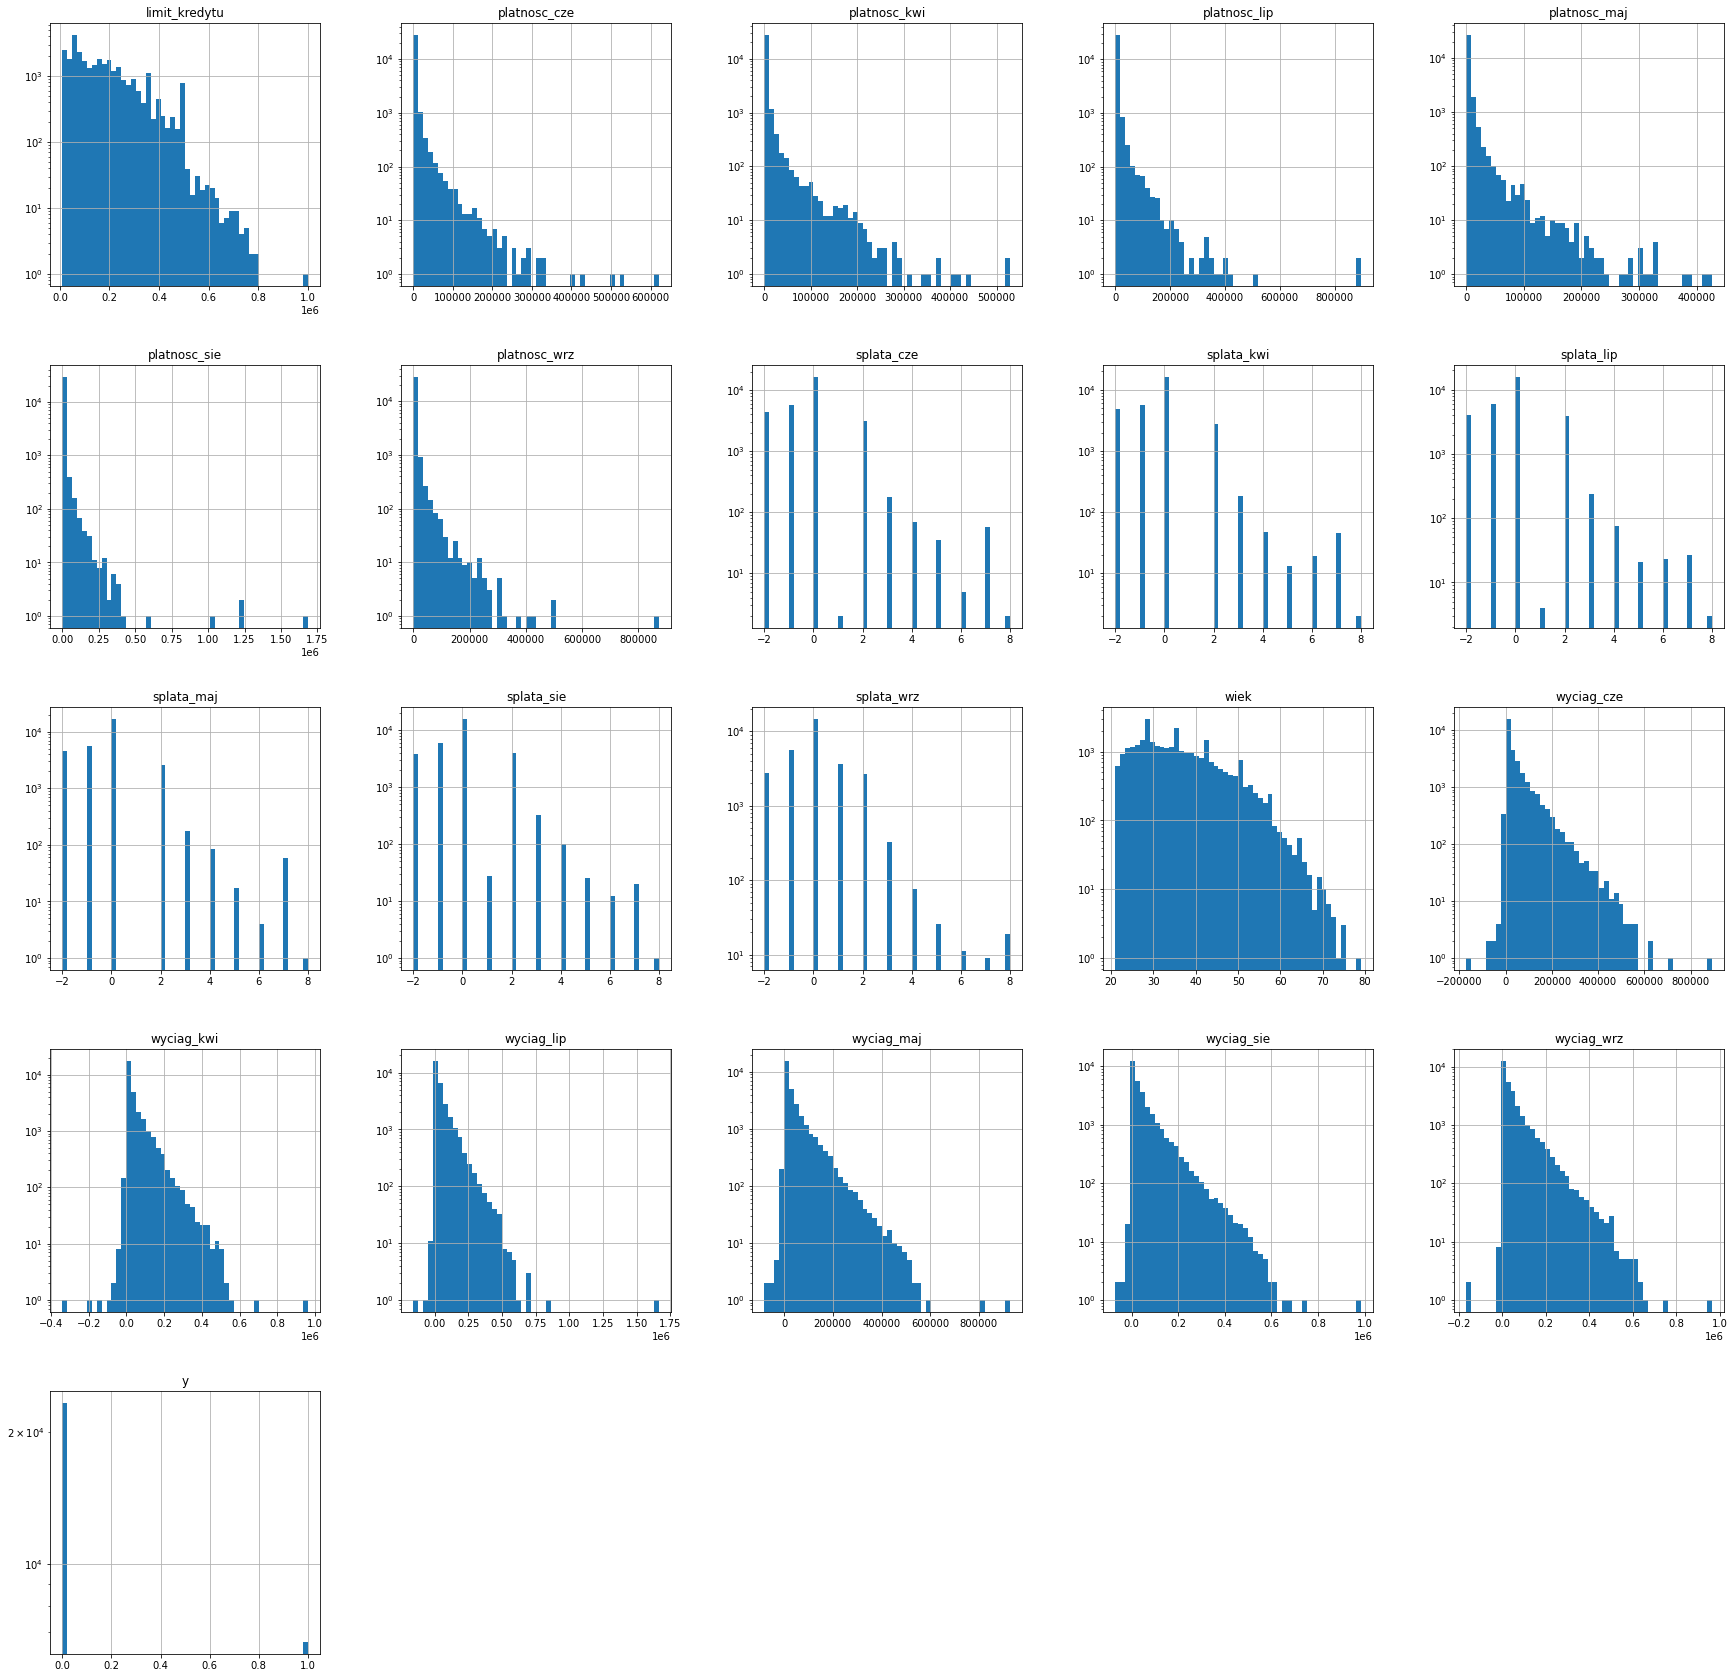

In [10]:
df.hist(figsize=(30,30), bins=50, log=True);

#### Analiza atrybutów numerycznych pod kątem rozkładu wartości i ew. wskazanie wartości odstających.

##### `limit_kredytu`

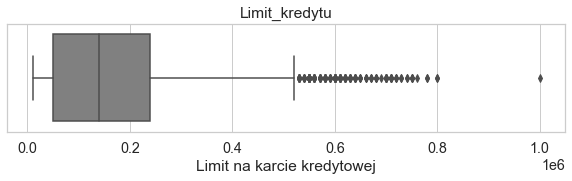

Atrybut nie ma rozkładu normalnego


In [11]:
plt.figure(figsize=(10,2))
sns.set(font_scale=1.3, style="whitegrid")
sns.boxplot(df['limit_kredytu'],palette = ['gray']).set(title = 'Limit_kredytu', xlabel = 'Limit na karcie kredytowej')
plt.show()

if(scipy.stats.normaltest(df['limit_kredytu'])[1] < 0.05): # Test na normalność rozkładu
    print('Atrybut nie ma rozkładu normalnego')
else:
    print('Atrybut ma rozkład normalny')

Rozkład jest prawostronnie skośny. Większość limitów na karcie jest mniejszych niż ok. 250000. Jest kilka wartości odstających w tym jedna wartość jest dużo większa od pozostałych i wynosi 1000000. 

##### `wiek`

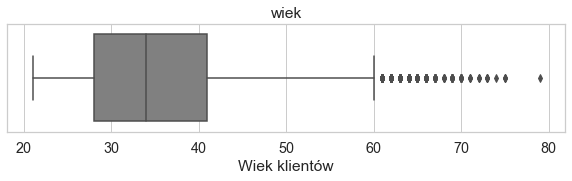

Atrybut nie ma rozkładu normalnego


In [12]:
plt.figure(figsize=(10,2))
sns.set(font_scale=1.3, style="whitegrid")
sns.boxplot(df['wiek'],palette = ['gray']).set(title = 'wiek', xlabel = 'Wiek klientów')
plt.show()

if(scipy.stats.normaltest(df['limit_kredytu'])[1] < 0.05): # Test na normalność rozkładu
    print('Atrybut nie ma rozkładu normalnego')
else:
    print('Atrybut ma rozkład normalny')

Rozkład jest prawostronnie skośny. Większość klientów to osoby w średnim wieku jednak jest też kilka osób w wieku emerytalnym.

##### `wartość na wyciągu (wyciag_kwi - wyciag_wrz)`

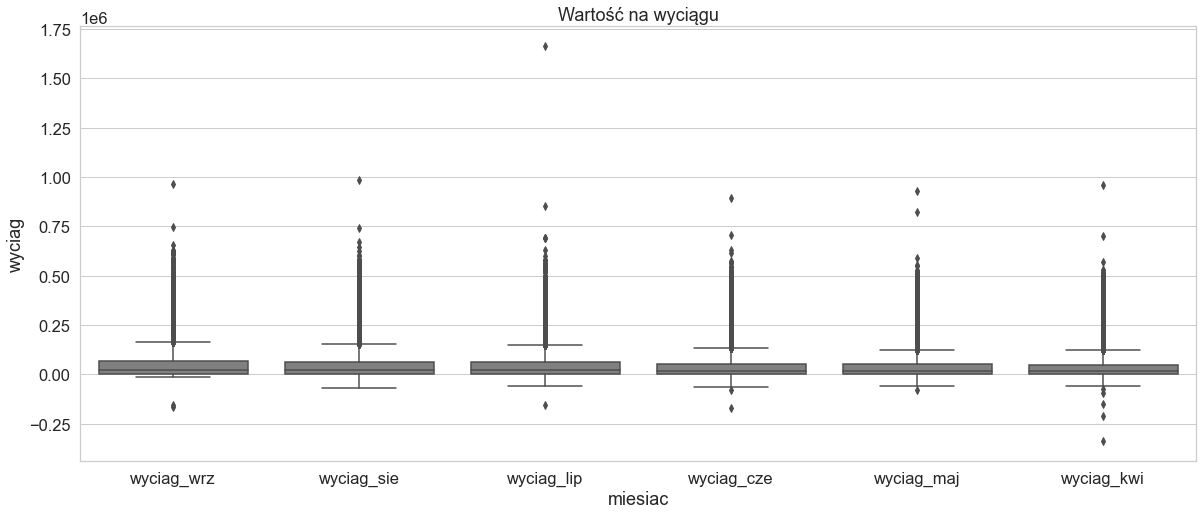

In [13]:
#Wszystkie atrybuty dotyczące wartości na wyciągu
wyciag = pd.melt(df, value_vars=['wyciag_wrz', 'wyciag_sie','wyciag_lip', 'wyciag_cze', 'wyciag_maj', 
                                 'wyciag_kwi'], var_name=['miesiac'], value_name = 'wyciag') 
plt.figure(figsize=(20,8))
sns.set(font_scale=1.5, style="whitegrid")
sns.boxplot(data = wyciag, y = 'wyciag', x = 'miesiac', palette = ['gray']).set(title = 'Wartość na wyciągu')
plt.show()


Rozkłady są prawostronnie skośne i nie mają rozkladu normalnego. Większość wartości na wyciągu jest mniejszych niż ok. 200000, ale są również wartości odstające.

##### `wartość poprzednich płatności  (platnosc_kwi - platnosc_wrz)`

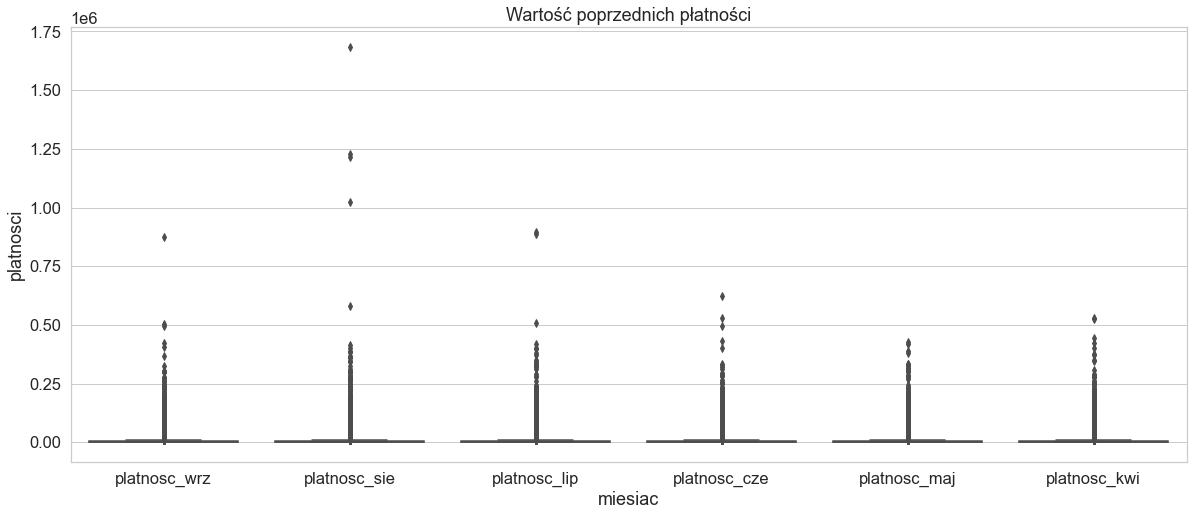

In [14]:
#Wszystkie atrybuty dotyczące wartości poprzednich platnosci
platnosci = pd.melt(df, value_vars=['platnosc_wrz', 'platnosc_sie', 'platnosc_lip', 'platnosc_cze', 'platnosc_maj', 
                                 'platnosc_kwi'], var_name=['miesiac'], value_name = 'platnosci') 
plt.figure(figsize=(20,8))
sns.set(font_scale=1.5, style="whitegrid")
sns.boxplot(data = platnosci, y = 'platnosci', x = 'miesiac', palette = ['gray'])\
   .set(title = 'Wartość poprzednich płatności')
plt.show()


Rozkłady są prawostronnie skośne i nie mają rozkladu normalnego. Większość wartości na wyciągu jest mniejszych niż ok. 100000, ale są również wartości odstające.

Podumowując na podstawie powyższej analizy można stwierdzić, że wszystkie atrybuty numeryczne posiadają wartości odstające oraz nie mają rozkładów normalnych (ich rozkłady mają skośności).
Powyższa wnioski zostaną wykorzystane przy doborze dalszych metod analizy.


<a class="anchor" id="a_kat"></a>
### Atrybuty kategoryzujące

### Porządkowe

##### `stan spłaty zadłużenia (splata_kwi - splata_wrz)`

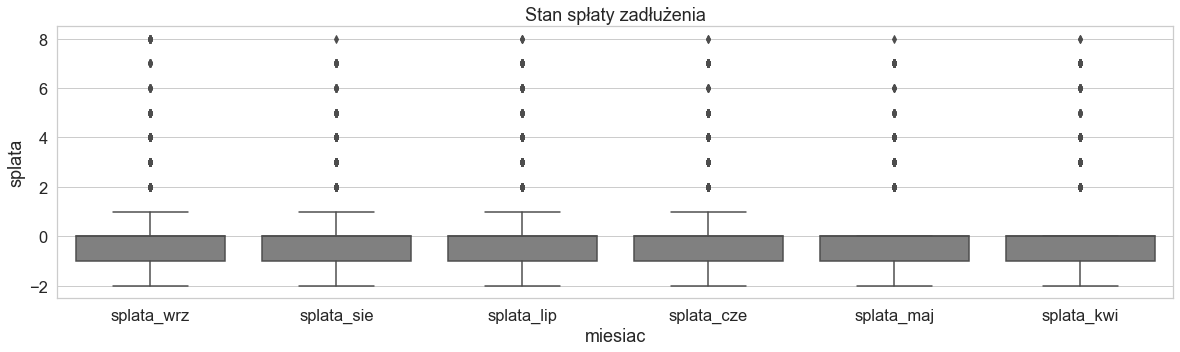

In [15]:
#Wszystkie atrybuty dotyczące stanu spłaty zadłużenia
splata = pd.melt(df, value_vars=['splata_wrz', 'splata_sie','splata_lip', 'splata_cze', 'splata_maj', 
                                    'splata_kwi'], var_name=['miesiac'], value_name = 'splata') 
plt.figure(figsize=(20,5))
sns.set(font_scale=1.5, style="whitegrid")
sns.boxplot(data = splata, y = 'splata', x = 'miesiac', palette = ['gray']).set(title = 'Stan spłaty zadłużenia',)
plt.show()


Większość zadłużenia jest spłacana w terminie (wartość -1). Jednak występują przypadki w których spłata przeciąga się do kilku miesięcy oraz występują przypadki braku salda płatności (wartości -2, 0).

### Nominalne

In [16]:
#ogólne porównanie
df.select_dtypes(include = ['object']).describe()

,plec,wyksztalcenie,stan_cywilny
count,29965,29965,29965
unique,2,5,4
top,kobieta,wyzsze,kawaler_panna
freq,18091,14019,15945


Z podanego zestawienia wynika, że najwięcej wśród klientów jest kobiet, większość klientów to osoby z wykształceniem wyższym i wyższym pełnym oraz najwięcej osób posiada stan cywilny kawaler lub panna.

##### `plec`

In [17]:
print(df['plec'].value_counts(normalize = True))

kobieta      0.603738
mezczyzna    0.396262
Name: plec, dtype: float64


W większości klientami są kobiety i stanowią ok. 60%.

##### `wyksztalcenie`

In [18]:
print(df['wyksztalcenie'].value_counts(normalize = True))

wyzsze          0.467846
wyzsze_pelne    0.352511
srednie         0.164025
nieznane        0.011513
inne            0.004105
Name: wyksztalcenie, dtype: float64


W znacznej większości klientami są osoby z wykształceniem wyższym i wyższym pełnym. Łącznie stanowią ok. 82% klientów.

##### `stan_cywilny`

In [19]:
print(df['stan_cywilny'].value_counts(normalize = True))

kawaler_panna    0.532121
w_zwiazku        0.455298
inny             0.010779
nieznany         0.001802
Name: stan_cywilny, dtype: float64


W większości klientami są osoby ze stanem cywilnym kawaler/panna (ok. 53%) ale również dużą liczbę stanowią klienci w związku (ok. 46%).

<a class="anchor" id="z_celu"></a>
### Zmienna objaśniana

In [20]:
print(df['y'].value_counts(normalize = True))

0    0.778742
1    0.221258
Name: y, dtype: float64


Ilość klientów, którzy nie spłacą zobowiązania w przyszłym miesiącu stanowi ok. 22% wszytkich klientów. Zbiór można uznać za niezbalansowany.

<a class="anchor" id="a_zal"></a>
## Analiza zależności
[Powrót do spisu treści](#toc)

<a class="anchor" id="num_celu"></a>
### Atrybuty numeryczne i kategoryzujące porządkowe a zmienna objaśniana

Do zbadania korelacji wykorzystano metodę rang Spearmana. 

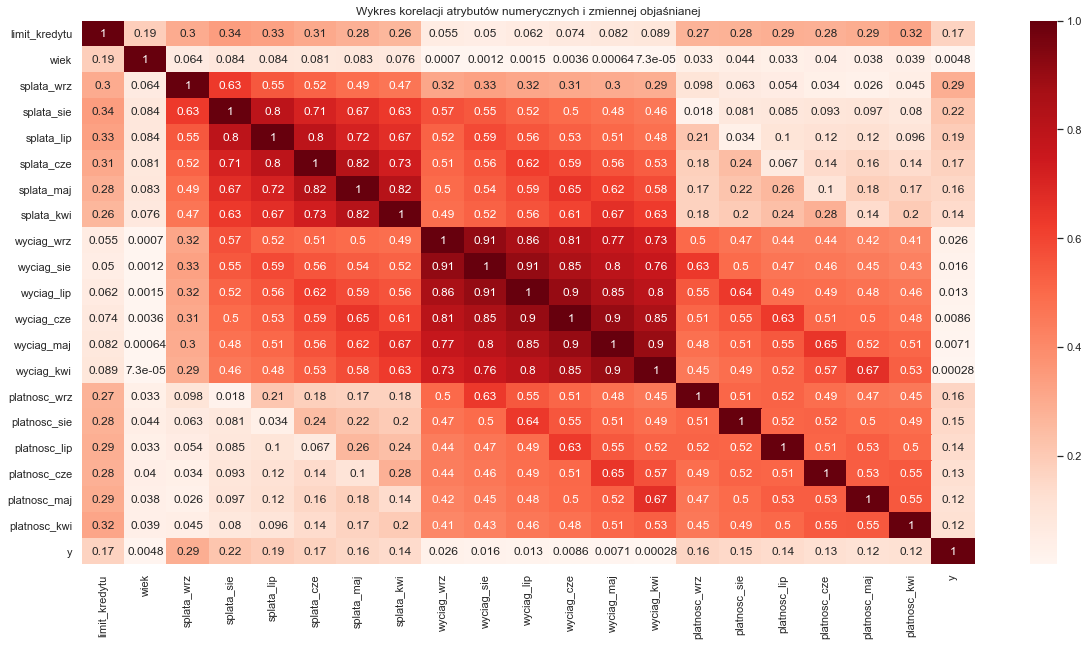

In [21]:
korelacja_num = pd.DataFrame(scipy.stats.spearmanr(df.drop(['plec', 'wyksztalcenie', 'stan_cywilny'], axis = 1))[0],
columns = df.drop(['plec', 'wyksztalcenie', 'stan_cywilny'], axis = 1).columns,
index = df.drop(['plec', 'wyksztalcenie', 'stan_cywilny'], axis = 1).columns) #bez atrybutów kategoryzujących

plt.figure(figsize=(20,10))
sns.set(font_scale=1)
sns.heatmap(korelacja_num.abs(), cmap="Reds", annot=True).set(title='Wykres korelacji atrybutów numerycznych i zmiennej objaśnianej')
plt.show()

Atrybuty z grupy *`stan spłaty`* są najbardziej skorelowane ze zmienną objaśnianą *`y`*. Korelacja wzrasta ze zbliżaniem się do października.<br>
*`Limit kredytu`* i atrybuty z grupy *`wartości płatności`* są w niewielkim stopniu skorelowane ze zmienną objaśnianą *`y`*.<br>
*`Wiek`* i atrybuty z grupy *`wartości wyciągu`* są tylko nieznacznie skorelowane ze zmienną objaśnianą *`y`*.<br>
Wydaje się być oczywiste, że `*wartość wyciągu*` jest mocno skorelowana z *`wartością płatności`*, a w szczególności zależna jest *`wartoścć płatności`* w danym miesiącu i *`wartość wyciągu`* w kolejnym miesiącu.<br>
*`Wiek`* praktycznie nie ma korelacji z żadnym z atrybutów (niewielka z *`limit kredytu`*).<br>

<a class="anchor" id="kat_celu"></a>
### Atrybuty kategoryzujące nominalne a zmienna objaśniana

y,0,1
wyksztalcenie,,
inne,116,7
nieznane,319,26
srednie,3678,1237
wyzsze,10691,3328
wyzsze_pelne,8531,2032


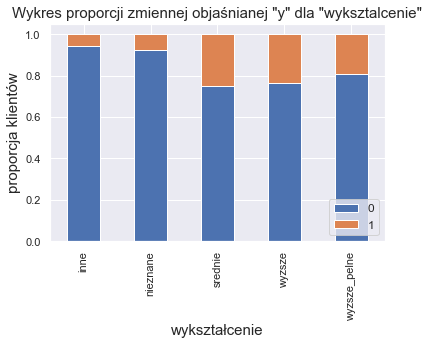

In [22]:
#Wykres proporcji zmiennej objaśnianej "y" dla wykształcenia
wyksz_y=pd.crosstab(df.wyksztalcenie,df.y)
wyksz_y.div(wyksz_y.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(6, 4))

plt.title('Wykres proporcji zmiennej objaśnianej "y" dla "wyksztalcenie"', fontsize=15)
plt.xlabel('wykształcenie', fontsize=15)
plt.ylabel('proporcja klientów', fontsize=15)
plt.legend(frameon=True,loc='lower right', fontsize=12)
wyksz_y

y,0,1
plec,,
kobieta,14330,3761
mezczyzna,9005,2869


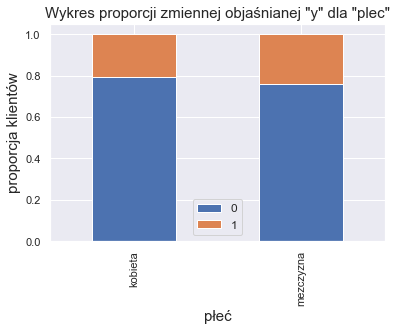

In [23]:
#Wykres proporcji zmiennej objaśnianej "y" dla płci
plec_y=pd.crosstab(df.plec,df.y)
plec_y.div(plec_y.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(6, 4))
plt.title('Wykres proporcji zmiennej objaśnianej "y" dla "plec"', fontsize=15)
plt.xlabel('płeć', fontsize=15)
plt.ylabel('proporcja klientów', fontsize=15)
plt.legend(fontsize=12)
plec_y

y,0,1
stan_cywilny,,
inny,239,84
kawaler_panna,12605,3340
nieznany,49,5
w_zwiazku,10442,3201


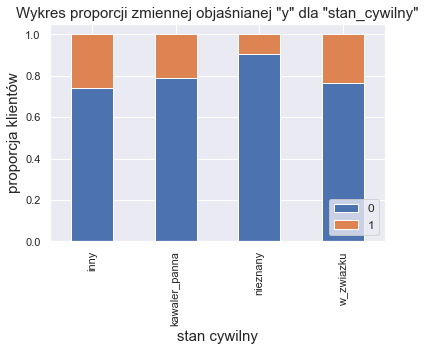

In [24]:
#Wykres proporcji zmiennej objaśnianej "y" dla stanu cywilnego
stan_cyw_y=pd.crosstab(df.stan_cywilny,df.y)
stan_cyw_y.div(stan_cyw_y.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,figsize=(6, 4))
plt.title('Wykres proporcji zmiennej objaśnianej "y" dla "stan_cywilny"', fontsize=15)
plt.xlabel('stan cywilny',fontsize=15)
plt.ylabel('proporcja klientów',fontsize=15)
plt.legend(loc='lower right', fontsize=12)
stan_cyw_y

#### Badanie korelacji przy pomocy współczynnika V Crammera

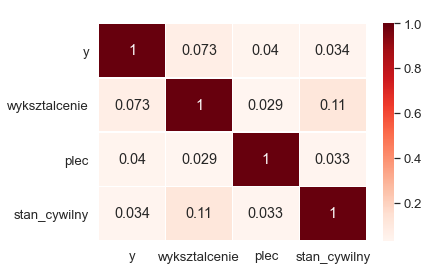

In [25]:
#Badanie zależności przy pomocy współczynnika V Crammera
def CramersV(x):
    a = scipy.stats.chi2_contingency(x)[0]/sum(x.sum())
    b = min(x.shape[0]-1, x.shape[1]-1,)
    return(np.sqrt(a/b))

def CalculateCrammersV(x):
    ret = []
    for m in x:
        row = []
        for n in x:
            cross_tab = pd.crosstab(x[m].values,x[n].values)
            row.append(CramersV(cross_tab))
        ret.append(row)
    return pd.DataFrame(ret, columns=x.columns, index=x.columns)

kateg_y = pd.DataFrame(CalculateCrammersV(df[['y','wyksztalcenie', 'plec', 'stan_cywilny']]).iloc[0,1:])
kateg_y.reset_index(inplace = True)

plt.figure(figsize=(6,4))
sns.set(font_scale=1.2)
sns.heatmap(CalculateCrammersV(df[['y','wyksztalcenie', 'plec', 'stan_cywilny']]), cmap="Reds", linewidths=.5, annot=True).set(title=' ')
plt.show()

Na podstawie powyższych wykresów proporcji występowania klientów wiarygodnych/niewiarygodnych dla poszczególnych atrybutów kategoryzujących oraz współczynników korelacji można stwierdzić, że zależność pomiędzy atrybutami kategoryzującymi a zmienną objaśniana nie jest duża. Największe zróżnicowanie proporcji występuje dla *`wyksztalcenia`* (np. dla średniego i wyższego wykształcenia jest duży udział zdarzeń pozytywnych w stosunku do łącznej ilości). Dla *`plec`* udział "1" dla mężczyzn jest nieznacznie większy niż dla kobiet. Dla stanu cywilnego *`nieznany`* jest mniej zdarzeń pozytywnych niż dla pozostałych.

<a class="anchor" id="dodatkowe"></a>
## Dodatkowe analizy
[Powrót do spisu treści](#toc)

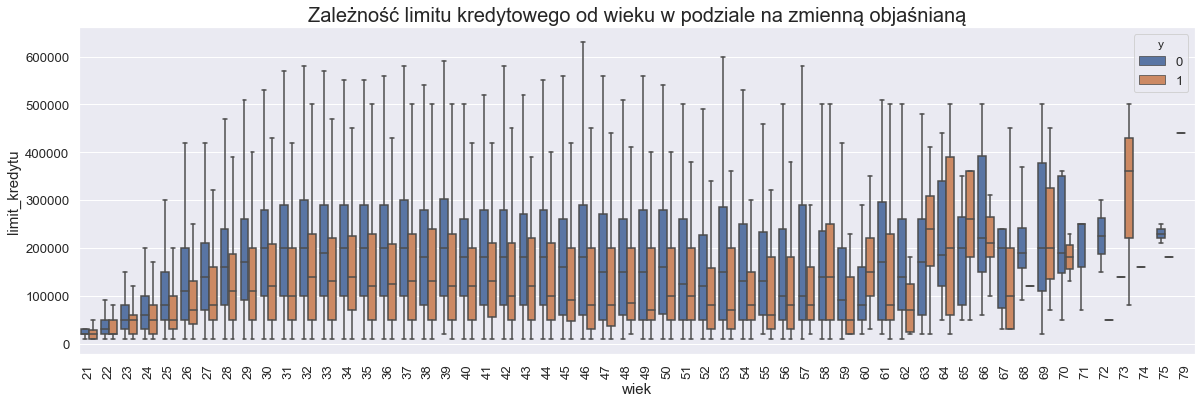

In [26]:
#Zależność limitu kredytowego od wieku w podziale na klienta wiarygodnego[0] / niewiarygodnego[1]
wykres, ax1 = plt.subplots(ncols=1, figsize=(20,6))
s = sns.boxplot(ax = ax1, x='wiek', y='limit_kredytu', hue='y',
                data=df,showfliers=False)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.xlabel('wiek',fontsize=15)
plt.ylabel('limit_kredytu',fontsize=15)
plt.title('Zależność limitu kredytowego od wieku w podziale na zmienną objaśnianą', fontsize=20)
plt.show()

Na powyższym wykresie widać wzrost limitu kredytowego w zależności od wieku do ok. 30 lat i stabilny poziom aż do wieku 60 lat. W tym okresie dla zdarzeń pozytywnych wartość średniej dla limit kredytowego jest niższa niż dla zdarzeń negatywnych. Po przekroczenie 60 roku większość ludzi przechodzi na emeryturę i zakres przyznanego limitu kredytowego bardziej się wacha i jest mniej stabilny. Po przekroczeniu 70 roku życia jest mało klientów i wyniki są bardziej losowe.

In [27]:
#średnie wartości poszczególnych atrybutów w zależności od wartości zmiennej objaśnianej
df.groupby('y').mean()

,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,wyciag_wrz,wyciag_sie,wyciag_lip,wyciag_cze,wyciag_maj,wyciag_kwi,platnosc_wrz,platnosc_sie,platnosc_lip,platnosc_cze,platnosc_maj,platnosc_kwi
y,,,,,,,,,,,,,,,,,,,,
0,178084.508249,35.421041,-0.211356,-0.299979,-0.314335,-0.353760,-0.387658,-0.403814,52058.720249,49779.099121,47592.314763,43665.240026,40580.691493,39090.665395,6315.052111,6648.593829,5760.523291,5306.992843,5254.618813,5726.355817
1,129984.567119,35.723529,0.668175,0.459879,0.363348,0.255656,0.168929,0.113122,48552.813122,47326.159578,45222.238311,42074.744193,39575.724585,38305.821418,3400.118401,3391.716290,3370.398944,3158.482504,3222.052790,3444.596531


Warto zauważyć, że ogólnie średnia limitu kredytowy, a co za tym idzie średnia wartości wyciągu i płatności w poszczególnych miesiącach jest mniejsza dla klientów oznaczonych jako niewiarygodni {1} w porównaniu do wiarygodnych {0}. To może oznaczać, że klienci niewiarygodni są raczej w grupie osób o mniejszym przyznanym limicie kredytu. Ponadto średnia wartość opóźnienia spłaty zobowiązania dla klientów niewiarygodnych jest dodatnia, a dla wiarygodnych ujemna, co jest w miarę logiczne - kliencie niespłacający zobowiązania w kolejnych miesiącach wkońcu stają się niewiarygodni.


<a class="anchor" id="przygotowanie"></a>
## Przygotowanie danych do modelowania
[Powrót do spisu treści](#toc)

<a class="anchor" id="odstajace"></a>
### Usunięcie odstających wartości atrybutów
Na podstawie analizy atrybutów zdecydowano o usunięciu 5% wartości odstających. Nie usuwano wartości odstających dla `zmiennej objaśnianej y`, `atrybutów kategoryzujących` oraz `atrybutów wiek`, `stan spłaty`.

In [28]:
#wybór wartości odstających
g_dolna = df.quantile(0.025)
g_gorna = df.quantile(0.975)
ilosc_odst = (df[g_gorna.index] > g_gorna).sum()
wart_odst = pd.DataFrame({'g_gorna':g_gorna, 'ilosc_odst':ilosc_odst})
print('Ilość wartości odstających: \n',wart_odst)

Ilość wartości odstających: 
                 g_gorna  ilosc_odst
limit_kredytu  500000.0         206
wiek               56.0         666
splata_wrz          2.0         463
splata_sie          2.0         483
splata_lip          2.0         389
splata_cze          2.0         348
splata_maj          2.0         341
splata_kwi          2.0         312
wyciag_wrz     262449.0         750
wyciag_sie     253568.2         750
wyciag_lip     243586.8         750
wyciag_cze     226695.0         750
wyciag_maj     211082.2         750
wyciag_kwi     205424.7         750
platnosc_wrz    32000.0         748
platnosc_sie    33000.0         749
platnosc_lip    30843.2         750
platnosc_cze    30222.5         750
platnosc_maj    30000.0         747
platnosc_kwi    35113.6         750
y                   1.0           0


In [29]:
#bez usuwania wartości odstających dla wybranych atrybutów dla których nie jest to konieczne
wart_odst.drop(['y', 'wiek', 'splata_wrz', 'splata_sie', 'splata_lip', 'splata_cze', 'splata_maj', 'splata_kwi'],
              inplace = True, axis = 0)

In [30]:
#usunięcie wartości odstajacych
for n in wart_odst.iterrows():
    df = df[df[n[0]] <= n[1]['g_gorna']]
print('Pozostała wielkość zbioru danych: \n',df.shape)

Pozostała wielkość zbioru danych: 
 (25702, 24)


<a class="anchor" id="kodowanie"></a>
### Kodowanie "gorącojedynkowe" atrybutów  kategoryzujących nominalnych


Dla każdego atrybutu, który ma wartości zawierające ciąg znaków została dodana dodatkowa kolumna z wartościami 0 lub 1.

In [31]:
df = pd.get_dummies(df)
df

,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,wyciag_wrz,wyciag_sie,...,plec_mezczyzna,wyksztalcenie_inne,wyksztalcenie_nieznane,wyksztalcenie_srednie,wyksztalcenie_wyzsze,wyksztalcenie_wyzsze_pelne,stan_cywilny_inny,stan_cywilny_kawaler_panna,stan_cywilny_nieznany,stan_cywilny_w_zwiazku
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,0,0,1,0,0,0,0,1
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,0,0,0,1,0,0,1,0,0
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,0,0,0,1,0,0,1,0,0
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,0,0,0,1,0,0,0,0,1
5,50000,37,0,0,0,0,0,0,64400,57069,...,1,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,80000,34,2,2,2,2,2,2,72557,77708,...,1,0,0,0,1,0,0,1,0,0
29995,220000,39,0,0,0,0,0,0,188948,192815,...,1,0,0,1,0,0,0,0,0,1
29996,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,1,0,0,1,0,0,0,1,0,0
29997,30000,37,4,3,2,-1,0,0,3565,3356,...,1,0,0,0,1,0,0,1,0,0


Z uwagi na możliwość wystąpienia współliniowości (atrybuty po podziale są skorelowane) została usunięta na stałe jedna kategoria atrybutów dla których zostały dodane więcej niż jedna kolumna dodatkowa opisująca kategorię atrybutu czyli dla *`stan_cywilny`*, *`wyksztalcenie`*, *`plec`*. Do usunięcia wybrano kategorię *`stan_cywilny_inny`*, *`wyksztalcenie_inne`* i *`plec_mezczyzna`*.

In [32]:
df.drop(axis = 1, labels = ['stan_cywilny_inny', 'wyksztalcenie_inne', 'plec_mezczyzna'], inplace = True)

<a class="anchor" id="podzial"></a>
### Podział zbioru na uczący i testowy

Dokonano podziału w stosunku: 80% – zbiór uczący, 20% – zbiór testowy.
Dodatkowo dokonano podziału zbioru uczącego na podzbiór uczący (75%) i podzbiór walidacyjny (25%) w celu dokonania sprawdzianu krzyżowego.

Przy podziale uwzględniono żeby wartości zmiennej objaśnianej były równo rozłożone pomiędzy poszczególne zbiory.

In [33]:
y = df.y.copy() #skopiowanie zmiennej objaśnianą "y" przed podziałem
df.drop('y', axis = 1, inplace = True) #usunięcie zmiennej objaśnianej ze zbioru przed podziałem

x_train, x_test, y_train, y_test = train_test_split(sm_api.add_constant(df).
                                                    rename(columns = {'const':'intercept'}), y, test_size = 0.2, 
                                                    random_state = 1, stratify = y)
x_train, x_vali, y_train, y_vali = train_test_split(x_train, y_train, test_size = 0.25, random_state = 1, 
                                                    stratify = y_train)

In [34]:
x_train.describe()
#x_test.describe()
#x_vali.describe()
#y_train.describe()
#y_test.describe()
#y_vali.describe()

,intercept,limit_kredytu,wiek,splata_wrz,splata_sie,splata_lip,splata_cze,splata_maj,splata_kwi,wyciag_wrz,...,platnosc_maj,platnosc_kwi,plec_kobieta,wyksztalcenie_nieznane,wyksztalcenie_srednie,wyksztalcenie_wyzsze,wyksztalcenie_wyzsze_pelne,stan_cywilny_kawaler_panna,stan_cywilny_nieznany,stan_cywilny_w_zwiazku
count,15420.0,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.00000,15420.000000,15420.000000,...,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,1.0,147775.097276,35.304150,0.022503,-0.091051,-0.133722,-0.194228,-0.25000,-0.280545,40810.149157,...,2519.747341,2520.320817,0.610246,0.011349,0.172309,0.474903,0.337613,0.531453,0.001621,0.456550
std,0.0,115608.283925,9.297713,1.132885,1.222616,1.218740,1.197022,1.16623,1.185455,50620.077710,...,3798.484528,4065.167089,0.487710,0.105928,0.377661,0.499386,0.472911,0.499026,0.040234,0.498125
min,1.0,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.00000,-2.000000,-11545.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,3072.750000,...,33.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,120000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,20079.500000,...,1200.000000,1102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.0,210000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,57928.000000,...,3058.000000,3011.250000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.0,500000.000000,75.000000,8.000000,8.000000,7.000000,8.000000,7.00000,8.000000,262138.000000,...,30000.000000,35012.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a class="anchor" id="kategoryzacja"></a>
### Kategoryzacja atrybutów

#### Kategoryzacji atrybutów z wykorzystaniem algorytmu drzewa decyzyjnego
Wykonanie kategoryzacji atrybutów poprzez wykorzystanie algorytmu drzewa decyzyjnego do budowy nowych atrybutów kategoryzujących na podstawie atrybutów już istniejących (numerycznych) w celu zwiększenia mocy predykcyjnej atrybutów. Kategoryzacje, a co za tym idzie dobór kryterium dodania nowego atrybutu przeprowadzono dla zbioru uczącego, a następnie dopasowano odpowiednio do zbioru walidacyjnego i testowego.

In [35]:
#Funkcja wyznaczająca nowe atrybuty z wykorzystaniem algorytmu drzewa decyzyjnego
def kategoryzacja_drzewem (x_train, x_vali, x_test, y_train):
    
    #Wybór do kategoryzacji atrybutów które mają więcej niż 8 wartości unikalanych (numerycznych).    
    atrybuty_kateg = [atrybut for atrybut in x_train.columns if x_train[atrybut].unique().shape[0] > 8]

    #Dodanie nowych atrybutów    
    for atrybut in atrybuty_kateg:
        dt_model = DecisionTreeClassifier(max_depth = 3)
        dt_model.fit(x_train[atrybut].values.reshape(-1, 1), y_train)
        kategorie = dt_model.apply(x_train[atrybut].values.reshape(-1, 1))

        x_train = x_train.assign(_bin = kategorie)
        x_vali = x_vali.assign(_bin = dt_model.apply(x_vali[atrybut].values.reshape(-1, 1)))
        x_test = x_test.assign(_bin = dt_model.apply(x_test[atrybut].values.reshape(-1, 1)))

        nazwa_atrybutu = atrybut + '_bin'

        x_train.rename(columns = {'_bin' : nazwa_atrybutu}, inplace = True)
        x_vali.rename(columns = {'_bin' : nazwa_atrybutu}, inplace = True)
        x_test.rename(columns = {'_bin' : nazwa_atrybutu}, inplace = True)

    return x_train, x_vali, x_test

#Wywołanie funkcji kategoryzacja_drzewem
x_train, x_vali, x_test = kategoryzacja_drzewem(x_train, x_vali, x_test, y_train)

<a class="anchor" id="dobor_kat"></a>
### Wybór atrybutów do modelowania

Wykonano dobór i zmniejszenie ilości atrybutów w celu zmniejszenia wymiarowości (uniknięcie przetrenowania modelu) przy jednoczesnym niezmniejszeniu skuteczności modelu. Przeprowadzono dobór najlepszych atrybutów na podstawie poziomu istotności z wykorzystaniem algorytmu lasów losowych. 

#### Dobór atrybutów metodą lasów losowych

 1) splata_wrz_bin                 0.058040
 2) wiek                           0.057219
 3) splata_wrz                     0.055611
 4) wyciag_wrz                     0.048411
 5) wyciag_sie                     0.043784
 6) wyciag_lip                     0.041436
 7) wyciag_cze                     0.040579
 8) wyciag_kwi                     0.040325
 9) wyciag_maj                     0.039394
10) platnosc_wrz                   0.038177
11) platnosc_sie                   0.037059
12) platnosc_lip                   0.036055
13) platnosc_kwi                   0.035389
14) platnosc_maj                   0.034041
15) platnosc_cze                   0.033414
16) limit_kredytu_bin              0.032733
17) splata_sie                     0.023386
18) wiek_bin                       0.021382
19) splata_sie_bin                 0.020739
20) splata_lip                     0.015854
21) platnosc_kwi_bin               0.013976
22) splata_lip_bin                 0.013755
23) splata_cze_bin              

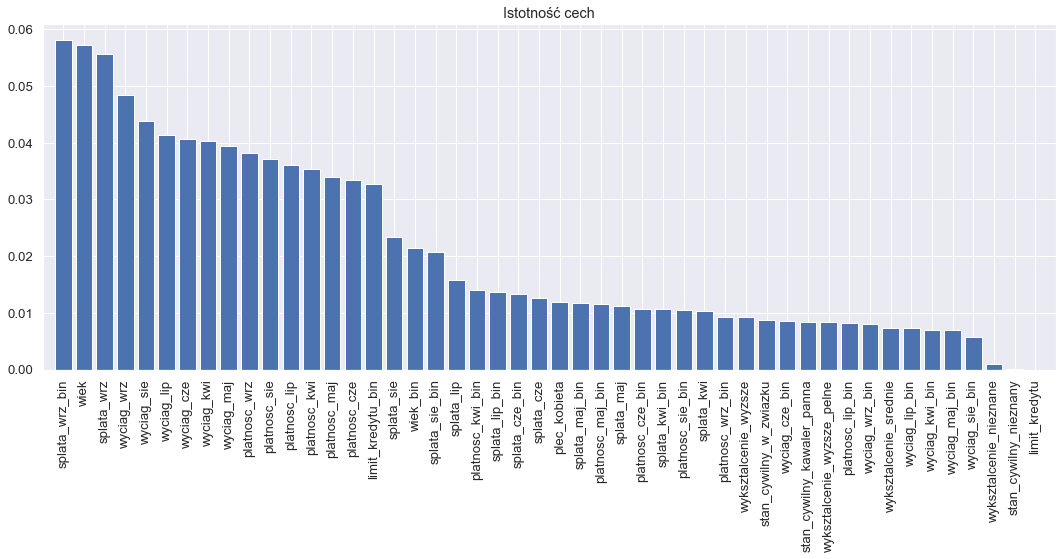

In [36]:
#Funkcja wyznaczająca poziom istotności atrybutów na podstawie algorytmu lasów losowych
def istotnosc_atrybutow_las(x_train, y_train, black_list):

    atrybuty_lasy = [atrybut for atrybut in x_train.columns if atrybut not in black_list]
    
    atrybuty = x_train.columns[1:]
    forest = RandomForestClassifier(n_estimators=500,random_state=1)
    forest.fit(x_train[atrybuty_lasy], y_train)
    istotnosc = forest.feature_importances_
    indeks = np.argsort(istotnosc)[::-1]

    for f in range(x_train[atrybuty_lasy].shape[1]):
        print("%2d) %-*s %f" % (f+1, 30,atrybuty[indeks[f]],istotnosc[indeks[f]]))


    plt.figure(figsize=(15,8))    
    plt.title('Istotność cech')
    plt.bar(range(x_train[atrybuty_lasy].shape[1]), istotnosc[indeks], align='center')
    plt.xticks(range(x_train[atrybuty_lasy].shape[1]), atrybuty[indeks], rotation=90)
    plt.xlim([-1, x_train[atrybuty_lasy].shape[1]])
    plt.tight_layout()
    plt.show()

    return istotnosc, indeks;

#do badania istotności pominięto atrybut limit_kredytu bo miał bardzo mały poziom istotności który wpływał na działanie algorytmu lasu losowego
black_list = ["limit_kredytu"]

#Wywołanie funkcji istotnosc_atrybutow_las
istotnosc, indeks = istotnosc_atrybutow_las(x_train, y_train, black_list)

Na podstawie powyższego wykresu oraz przeprowadzonych testów uzyskiwanych wyników modelowania wybrano atrybuty z poziomem istotności powyżej 0.009.

In [37]:
#Funkcja wyznaczająca najlepsze atrybuty na podstawie zadanego poziomu istotności atrybutów
def wybor_atrybutow_las(x_train, istotnosc, indeks, black_list, poziom):
    atrybuty_wybrane=[]
    atrybuty = [atrybut for atrybut in x_train.columns if atrybut not in black_list]

    for f in range(x_train[atrybuty].shape[1]):
        if istotnosc[indeks[f]] > poziom:
            atrybuty_wybrane.append(atrybuty[indeks[f]])
            
    atrybuty_wybrane.append('intercept')
    
    return atrybuty_wybrane;

atrybuty_wybrane = wybor_atrybutow_las(x_train, istotnosc, indeks, black_list, 0.009)

print('Zostały wybrane następujące atrybuty: \n',atrybuty_wybrane)


Zostały wybrane następujące atrybuty: 
 ['splata_wrz_bin', 'wiek', 'splata_wrz', 'wyciag_wrz', 'wyciag_sie', 'wyciag_lip', 'wyciag_cze', 'wyciag_kwi', 'wyciag_maj', 'platnosc_wrz', 'platnosc_sie', 'platnosc_lip', 'platnosc_kwi', 'platnosc_maj', 'platnosc_cze', 'limit_kredytu_bin', 'splata_sie', 'wiek_bin', 'splata_sie_bin', 'splata_lip', 'platnosc_kwi_bin', 'splata_lip_bin', 'splata_cze_bin', 'splata_cze', 'plec_kobieta', 'splata_maj_bin', 'platnosc_maj_bin', 'splata_maj', 'platnosc_cze_bin', 'splata_kwi_bin', 'platnosc_sie_bin', 'splata_kwi', 'platnosc_wrz_bin', 'wyksztalcenie_wyzsze', 'intercept']


In [38]:
'''
#Badanie najlepszego poziomu istotności
i=0
auc_max=0
poziom_istotnosci=0
for f in range(int((max(istotnosc))/0.001)+1):
    atrybuty_wybrane = wybor_atrybutow_las(x_train, istotnosc, indeks, black_list, i)
    
    model = Logit(y_train, x_train[atrybuty_wybrane]).fit(disp = 0) #wykonanie modelu dla danych uczących
    y_pred = model.predict(x_vali[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych
    fpr, tpr, thresholds = roc_curve(y_vali, y_pred) #wskaźniki modelu
    gini = 2 * auc(fpr, tpr) - 1    # współczynnik giniego

    print('Dla poziomu isttności', i)
    print('Pole pod krzywą ROC - AUC: %0.2f', auc(fpr, tpr))
    #print('Współczynnik Giniego: %0.2f' % gini)
    
    if auc(fpr, tpr) >= auc_max:
        auc_max = auc(fpr, tpr)
        poziom_istotnosci = i
    
    i=i+0.001;


auc_max
poziom_istotnosci

'''

"\n#Badanie najlepszego poziomu istotności\ni=0\nauc_max=0\npoziom_istotnosci=0\nfor f in range(int((max(istotnosc))/0.001)+1):\n    atrybuty_wybrane = wybor_atrybutow_las(x_train, istotnosc, indeks, black_list, i)\n    \n    model = Logit(y_train, x_train[atrybuty_wybrane]).fit(disp = 0) #wykonanie modelu dla danych uczących\n    y_pred = model.predict(x_vali[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych\n    fpr, tpr, thresholds = roc_curve(y_vali, y_pred) #wskaźniki modelu\n    gini = 2 * auc(fpr, tpr) - 1    # współczynnik giniego\n\n    print('Dla poziomu isttności', i)\n    print('Pole pod krzywą ROC - AUC: %0.2f', auc(fpr, tpr))\n    #print('Współczynnik Giniego: %0.2f' % gini)\n    \n    if auc(fpr, tpr) >= auc_max:\n        auc_max = auc(fpr, tpr)\n        poziom_istotnosci = i\n    \n    i=i+0.001;\n\n\nauc_max\npoziom_istotnosci\n\n"

<a class="anchor" id="model"></a>
## Model Regresja logistyczna
[Powrót do spisu treści](#toc)

<a class="anchor" id="budowa"></a>
### Budowa modelu

Do wykonania modelu została wykorzystany algorytm regresji logistycznej z biblioteki *statsmodels*.


In [39]:
model = Logit(y_train, x_train[atrybuty_wybrane]).fit(disp = 0) #wykonanie modelu dla danych uczących
y_pred = model.predict(x_vali[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych

<a class="anchor" id="ocena"></a>
### Ocena modelu dla zbioru walidacyjnego

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                15420
Model:                          Logit   Df Residuals:                    15385
Method:                           MLE   Df Model:                           34
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                  0.1753
Time:                        20:40:23   Log-Likelihood:                -6934.8
converged:                       True   LL-Null:                       -8409.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
splata_wrz_bin           0.7019      0.035     20.334      0.000       0.634       0.770
wiek                     0.0036      0.004      0.922      0.357      -0.004       0.011
splata_wrz              -0.4561      0.052     -8.760      0.000      -0.558      -0.354
wyciag_wrz           -8.194e-06   2.18e-06     -3.750      0.000   -1.25e-05   -3.91e-06
wyciag_sie            5.127e-06   3.05e-06      1.678      0.093    -8.6e-07    1.11e-05
wyciag_lip            5.012e-06   2.79e-06      1.794      0.073   -4.64e-07    1.05e-05
wyciag_cze            1.787e-07   2.81e-06      0.064      0.949   -5.33e-06    5.69e-06
wyciag_kwi            7.556e-06   3.09e-06      2.446      0.014     1.5e-06    1.36e-05
wyciag_maj           -5.119e-06   3.76e-06     -1.362      0.173   -1.25e-05    2.25e-06
platnosc_wrz          3.938e-06   8.58e-06      0.459      0.646   -1.29e-05    2.08e-05
platnosc_sie         -5.036e-06   8.92e-06     -0.565      0.572   -2.25e-05    1.24e-05
platnosc_lip         -1.365e-05   8.24e-06     -1.656      0.098   -2.98e-05    2.51e-06
platnosc_kwi          3.096e-07   9.55e-06      0.032      0.974   -1.84e-05     1.9e-05
platnosc_maj          -2.61e-05   1.22e-05     -2.148      0.032   -4.99e-05   -2.28e-06
platnosc_cze          2.128e-05   9.52e-06      2.235      0.025    2.62e-06    3.99e-05
limit_kredytu_bin       -0.0300      0.008     -3.748      0.000      -0.046      -0.014
splata_sie              -0.5520      0.102     -5.428      0.000      -0.751      -0.353
wiek_bin                 0.0122      0.016      0.777      0.437      -0.019       0.043
splata_sie_bin           0.4041      0.072      5.648      0.000       0.264       0.544
splata_lip              -0.1829      0.174     -1.052      0.293      -0.524       0.158
platnosc_kwi_bin        -0.0261      0.011     -2.299      0.021      -0.048      -0.004
splata_lip_bin           0.1821      0.121      1.504      0.133      -0.055       0.419
splata_cze_bin           0.2081      0.140      1.483      0.138      -0.067       0.483
splata_cze              -0.1675      0.202     -0.830      0.406      -0.563       0.228
plec_kobieta            -0.1268      0.044     -2.877      0.004      -0.213      -0.040
splata_maj_bin           0.2798      0.131      2.132      0.033       0.023       0.537
platnosc_maj_bin        -0.0147      0.015     -0.959      0.337      -0.045       0.015
splata_maj              -0.3818      0.192     -1.984      0.047      -0.759      -0.005
platnosc_cze_bin        -0.0976      0.018     -5.408      0.000      -0.133      -0.062
splata_kwi_bin          -0.1794      0.093     -1.935      0.053      -0.361       0.002
platnosc_sie_bin        -0.0511      0.010     -5.219      0.000      -0.070      -0.032
splata_kwi               0.2984      0.113      2.633      0.008       0.076       0.521
platnosc_wrz_bin        -0.0792      0.010     -8.256      0.000      -0.098      -0.060
wyksztalcenie_wyzsze     0.0462      

Podany powyżej współczynnik `coef` wskazuje logarytmy szans zajścia niespłacenia kredytu dla poszczególnych atrybutów. Im większe wartości tym większa szansa niespałcenia kredytu. Najwyższy wpływ na niespłacenie kredytu mają atrybuty związane ze stanem spłaty kredytu we wcześniejszych miesiącach, a szczególnie w miesiącu poprzedzającym badany miesiąc (co jest w miarę oczywiste).


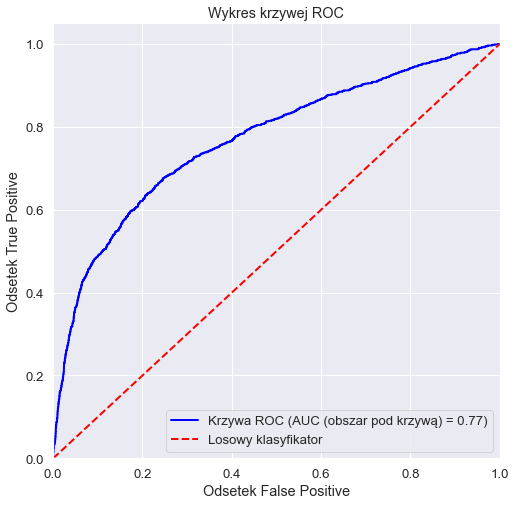

Pole pod krzywą ROC - AUC: 0.77
Współczynnik Giniego: 0.54


In [41]:
#Funkcja wyliczająca wskaźniki oceny modelu
def ocena_modelu(y_vali, y_pred):
    fpr, tpr, thresholds = roc_curve(y_vali, y_pred) #wskaźniki modelu
    gini = 2 * auc(fpr, tpr) - 1    # współczynnik giniego
  
    plt.figure(figsize=(8,8))
    lw=2
    plt.plot(fpr, tpr, color='blue',lw=lw, label='Krzywa ROC (AUC (obszar pod krzywą) = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label='Losowy klasyfikator')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Odsetek False Positive')
    plt.ylabel('Odsetek True Positive')
    plt.title('Wykres krzywej ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    print('Pole pod krzywą ROC - AUC: %0.2f' % auc(fpr, tpr))
    print('Współczynnik Giniego: %0.2f' % gini);


#Wywołanie funkcji do oceny modelu  
ocena_modelu(y_vali, y_pred)


Wykres Krzywej ROC jest najbardziej oddalony od lini losowego klasyfikatora w początkowym fragmencie i osiąga maksimum około pierwszej ćwiartki wykresu. Wskazuje to, że szukany optymalny punkt odcięcia (wyznaczony w kolejnym etapie) będzie znajdował się w tym obszarze.<br>
Wartość AUC oraz współczynnika Giniego są akceptowalne, choć ich wartości nie są bardzo duże.

<a class="anchor" id="model_fin"></a>
## Finalna weryfikacja jakości modelu
[Powrót do spisu treści](#toc)

Finalna weryfikacja modelu została przeprowadzona na zbiorze danych testowych, przy uwzględnieniu w modelowaniu  wybranych na wcześniejszym etapie atrybutów.

<a class="anchor" id="budowa_fin"></a>
### Model finalny

In [42]:
model_fin = Logit(y_train, x_train[atrybuty_wybrane]).fit(disp = 0)
y_pred_fin = model_fin.predict(x_test[atrybuty_wybrane])

<a class="anchor" id="ocena_fin"></a>
### Ocena modelu dla zbioru testowego

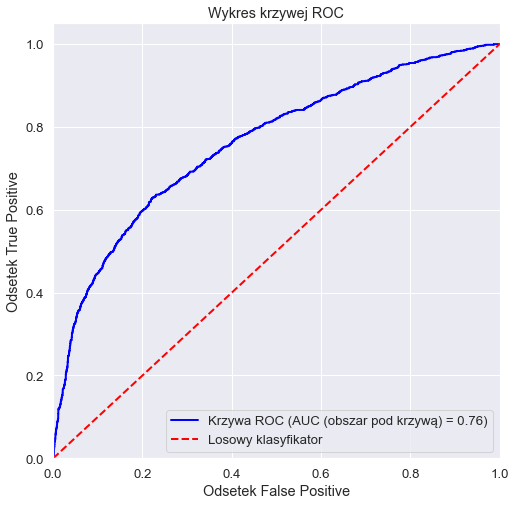

Pole pod krzywą ROC - AUC: 0.76
Współczynnik Giniego: 0.52


In [43]:
ocena_modelu(y_test, y_pred_fin)

Jak widać finalny model klasyfikatora ma prawie identyczne parametry jakości w porównaniu do wartości ze zbioru walidacyjnego i moża je uznać za zadawalające. Wyniki dla zbioru testowego nie odbiegają od wyników dla zbioru walidacyjnego więc model można uznać za nieprzetrenowany i powinien uzyskiwać podobne wyniki na rzeczywistych danych.

<a class="anchor" id="punkt"></a>
### Wyznaczanie optymalnego punktu odcięcia

W celu ostatecznej weryfikacji jakości modelu zostały wzięte pod uwagę uwarunkowania biznesowe procesu przyznawania kredytu. Na podstawie otrzymanych wyników modelowania przy zastosowaniu zbioru danych testowych został wyznaczony punkt odcięcia. Założono, że najoptymalniejszy punktu odcięcia będzie odpowiadał maksymalnemu dochodowi banku osiągniętemu dla wyznaczonych ilości klientów którym przyznano kredyt. Zgodnie z założeniami podanymi na początku dochód banku został określony jako:

*dochód = wiarygodni klienci którym przyznano kredyt * zysk - niewiarygodni klienci którym przyznano kredyt * strata*

In [44]:
def punkt_odciecia(y_test, y_pred_fin, zysk,strata):
    punkty_odciecia = np.arange(0, 1.01, 0.01) #punkty odcięcia od 0 do 1 z krokiem co 0.01

    #wyznaczenie dochodów dla poszczególnych punktów odcięcia
    dochody = {}
    for punkt_odciecia in punkty_odciecia:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fin>punkt_odciecia).ravel()
        dochod = tn * zysk + fn * -strata
        dochody[punkt_odciecia] = dochod
    dochody = pd.Series(dochody)

    #wyznaczenie maks. dochodu
    max_dochod = dochody.iloc[dochody.argmax()]
    punkt_odciecia_fin = dochody.iloc[dochody.argmax():dochody.argmax()+1].index[0]
    
    return  punkt_odciecia_fin, max_dochod, dochody;

#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 50
punkt_odciecia_fin, max_dochod, dochody_rl = punkt_odciecia(y_test, y_pred_fin, 15, 50)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.'
          .format(max_dochod, punkt_odciecia_fin))

Największy dochód wynosi: 23475, któremu odpowiada punkt odcięcia: 0.23.


<a class="anchor" id="ocena_punkt"></a>
### Ocena klasyfikatora z uwzględnieniem  optymalnego punktu odcięcia
 Dla obliczonej wartości punktu odcięcia wyznaczono wskaźniki jakości modelu oraz macierz pomyłek.

#### Macierz pomyłek i wskaźniki klasyfikacji

|  | Prognozowane "0"  | Prognozowane "1"  
------------ | ------------- | -------------
Prawdziwe "0" | TN | FP
Prawdziwe "1" | FN | TP

Zgodnie z założeniami przy podjęciu określonej decyzji mogą wystąpić następujące sytuacje:
*    True Negative: przyznanie karty kredytowej i spłacanie zadłużenia
*    False Negative: przyznanie karty kredytowej i niespłacanie zadłużenia
*    True Positive: nieprzyznanie karty kredytowej i niespłacanie zadłużenia
*    False Positive: nieprzyznanie karty kredytowej i spłacanie zadłużenia


In [45]:
def wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_fin>punkt_odciecia_fin).ravel()
    dokladnosc = (tn+tp) / (tn+tp+fn+fp)
    blad = (fn+fp) / (tn+tp+fn+fp)
    specyficznosc = tn / (tn+fp)
    czulosc = tp / (tp + fn)

    macierz_pomylek = pd.DataFrame(confusion_matrix(y_test, y_pred_fin>punkt_odciecia_fin),
                                   columns = ['Prognozowane "0"', 'Prognozowane "1"'],
                                   index = ['Prawdziwe "0"', 'Prawdziwe "1"'])
    print(classification_report(y_test, y_pred_fin>punkt_odciecia_fin))
    print('Dokładność: {}'.format(dokladnosc.round(2)))
    print('Błąd: {}'.format(blad.round(2)))
    print('Specyficzność: {}'.format(specyficznosc.round(2)))
    print('Czułość: {}'.format(czulosc.round(2)))
    print(macierz_pomylek) 
    return tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3933
           1       0.46      0.63      0.53      1208

    accuracy                           0.74      5141
   macro avg       0.67      0.70      0.68      5141
weighted avg       0.78      0.74      0.75      5141

Dokładność: 0.74
Błąd: 0.26
Specyficzność: 0.78
Czułość: 0.63
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              3055               878
Prawdziwe "1"               447               761


<a class="anchor" id="rentownosc"></a>
### Podsumowanie wyników i wyznaczenie rentowności
Rentowność klasyfikatora obliczana jest z uwzględnieniem optymalnego punktu odcięcia

In [46]:
#Założone wartości zysku i straty
zysk = 15
strata = 50

print('Dla założonych zysku {} i straty {} otrzymano: \n'.format(zysk,strata))
print('- Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))
print('- Wartość uzyskanego dochodu: ', max_dochod)

print('- Ilość badanych klientów:', tn + fn + fp + tp)
print('- Ilość klientów sklasyfikowanych jako wiarygodnych:', tn + fn)
print('- Ilość klientów sklasyfikowanych jako niewiarygodnych:', fp + tp)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych:', tn)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych:', fn)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', fp)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', tp)

Dla założonych zysku 15 i straty 50 otrzymano: 

- Rentowność: 6.7%
- Wartość uzyskanego dochodu:  23475
- Ilość badanych klientów: 5141
- Ilość klientów sklasyfikowanych jako wiarygodnych: 3502
- Ilość klientów sklasyfikowanych jako niewiarygodnych: 1639
- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych: 3055
- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych: 447
- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 878
- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 761


Na podstawie przeprowadzonej analizy wykonanego modelu można stwierdzić, że jakość modelu biorąc pod uwagę uzyskany dochód z całego portfela kredytów jest satysfakcjonujący. 
Model całkiem dobrze klasyfikuje klientów niewiarygodnych. Wyznaczona dokładność jest dobra, choć dla sytuacji najgorszej (klientów niewiarygodnych, a sklasyfikowanych jako wiarygodnych) ilość klientów wynosi 447. Czułość, która wskazuje udział klientów
sklasyfikowanych poprawnie jako niewiarygodnych w ogólnej liczbie klientów niewiarygodnych jest poprawna. Specyficzność jest wysoka, ale nominalnie model klasyfikuje dużo klientów wiarygodnych jako niewiarygodnych (FP=878), co oznacza niewykorzystanie potencjalnego zysku z wiarygodnych klientów (zgodnie z założeniami nie wzięto tego pod uwagę do oceny rentowności modelu). 

Prawdopodobnie należałoby jeszcze poprawić dobór parametrów lub zastosować transformacje atrybutów, ale mogłoby to też mieć wpływ na interpretowalność modelu. 

<a class="anchor" id="inne_doch"></a>
### Wyznaczenie dochodów dla innych zysków i strat dla modelu na podstawie regresji logistycznej

In [47]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 75
punkt_odciecia_fin_rl_15_75, max_dochod_rl_15_75, dochody_rl_15_75 = punkt_odciecia(y_test, y_pred_fin, 15, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_rl_15_75, punkt_odciecia_fin_rl_15_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_rl_15_75)

#Założone wartości zysku i straty
zysk = 15
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 13950, któremu odpowiada punkt odcięcia: 0.17.

              precision    recall  f1-score   support

           0       0.89      0.60      0.71      3933
           1       0.37      0.77      0.50      1208

    accuracy                           0.64      5141
   macro avg       0.63      0.68      0.61      5141
weighted avg       0.77      0.64      0.66      5141

Dokładność: 0.64
Błąd: 0.36
Specyficzność: 0.6
Czułość: 0.77
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              2345              1588
Prawdziwe "1"               283               925

 Rentowność: 5.31%


In [48]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 10 i straty równej 75
punkt_odciecia_fin_rl_10_75, max_dochod_rl_10_75, dochody_rl_10_75 = punkt_odciecia(y_test, y_pred_fin, 10, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_rl_10_75, punkt_odciecia_fin_rl_10_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_rl_10_75)

#Założone wartości zysku i straty
zysk = 10
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 4075, któremu odpowiada punkt odcięcia: 0.1.

              precision    recall  f1-score   support

           0       0.94      0.22      0.35      3933
           1       0.27      0.95      0.42      1208

    accuracy                           0.39      5141
   macro avg       0.60      0.58      0.39      5141
weighted avg       0.78      0.39      0.37      5141

Dokładność: 0.39
Błąd: 0.61
Specyficzność: 0.22
Czułość: 0.95
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"               850              3083
Prawdziwe "1"                59              1149

 Rentowność: 4.48%


<a class="anchor" id="model_xgb"></a>
## Model XGBoost
[Powrót do spisu treści](#toc)

<a class="anchor" id="hiperparametry_xgb"></a>
### Optymalizacja hiperparametrów modelu
Przed przystąpieniem do budowy modelu został przeprowadzony dobór hiperparamterów dla algorytmu XGBoost z zastosowaniem metody losowego doboru przy pomocy funkcji RandomizedSearchCV.

In [49]:
#określenie zakresów możliwych wartości hiperparametrów
parametry_xgb = {
    'n_estimators' : randint(50, 500),
    'max_depth' : randint(2, 10),
    'learning_rate' : uniform(loc = 0, scale = 1),
    'gamma' : uniform(loc = 0, scale = 1),
    'min_child_weight' : randint(1, 5),
    'subsample': uniform(loc = 0, scale = 1),
    'colsample_bytree': uniform(loc = 0, scale = 1),
    'reg_alpha' : uniform(loc = 0, scale = 1),
    'reg_lambda' : uniform(loc = 0, scale = 1),    
    'booster' : ['gbtree', 'gblinear', 'dart'],
    'n_jobs' : [2]
}

In [50]:
#po jednym wyznaczeniu najlepszych parametrów zaznaczenie poniższego kodu żeby się nie wykonywał bo trwa to długo
"""
def losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):

    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)
    rs.fit(x, y.values.ravel())
    wybrane_parametry = rs.best_params_
    return wybrane_parametry;
    

wybrane_parametry_xgb = losowa_optymalizacja_hp(x_train, y_train, parametry_xgb, XGBClassifier(), n_iter=20, n_jobs = 2, cv = 5)
"""

'\ndef losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):\n\n    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)\n    rs.fit(x, y.values.ravel())\n    wybrane_parametry = rs.best_params_\n    return wybrane_parametry;\n    \n\nwybrane_parametry_xgb = losowa_optymalizacja_hp(x_train, y_train, parametry_xgb, XGBClassifier(), n_iter=20, n_jobs = 2, cv = 5)\n'

In [51]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#1 zestaw

wybrane_parametry_xgb1 = {'booster': 'gbtree',
 'colsample_bytree': 0.8753771345781897,
 'gamma': 0.48883529942357284,
 'learning_rate': 0.2058684382998024,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 83,
 'n_jobs': 2,
 'reg_alpha': 0.45215106729387755,
 'reg_lambda': 0.34681411765531367,
 'subsample': 0.21734404631007365}


In [52]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#2 zestaw

wybrane_parametry_xgb2 = {'booster': 'dart',
 'colsample_bytree': 0.9605376499649342,
 'gamma': 0.4384656850867038,
 'learning_rate': 0.025148695022606304,
 'max_depth': 2,
 'min_child_weight': 3,
 'n_estimators': 348,
 'n_jobs': 2,
 'reg_alpha': 0.9064044727851012,
 'reg_lambda': 0.52273189331008,
 'subsample': 0.4914632579512438}


In [53]:
#wybór odpowiedniego zestawu hiperparametrów dla modelu

wybrane_parametry_xgb=wybrane_parametry_xgb2

<a class="anchor" id="budowa_xgb"></a>
### Budowa modelu

Do wykonania modelu została wykorzystany algorytm *XGBClassifier* z biblioteki *xgboost*.


In [54]:
model_xgb = XGBClassifier(**wybrane_parametry_xgb) #wykonanie modelu dla danych uczących
model_xgb.fit(x_train[atrybuty_wybrane], y_train.values.ravel())
y_pred_xgb = model_xgb.predict_proba(x_vali[atrybuty_wybrane])#sprawdzenie modelu dla danych walidacyjnych

<a class="anchor" id="ocena_xgb"></a>
### Ocena modelu dla zbioru walidacyjnego

In [55]:
#ocena istotności atrybutów
pd.DataFrame(model_xgb.feature_importances_, index = x_train[atrybuty_wybrane].columns)\
                                                        .sort_values(by = 0, ascending = False)

,0
splata_wrz_bin,0.196982
splata_wrz,0.126508
splata_sie_bin,0.060953
splata_lip,0.051398
splata_sie,0.047753
splata_cze_bin,0.047536
splata_kwi,0.039380
splata_maj_bin,0.036395
splata_kwi_bin,0.029926
platnosc_wrz_bin,0.025933


Na podstawie funkcji feature_importances_ określono, że najwyższy wpływ na niespłacenie kredytu mają atrybuty związane ze stanem spłaty kredytu we wcześniejszych miesiącach.


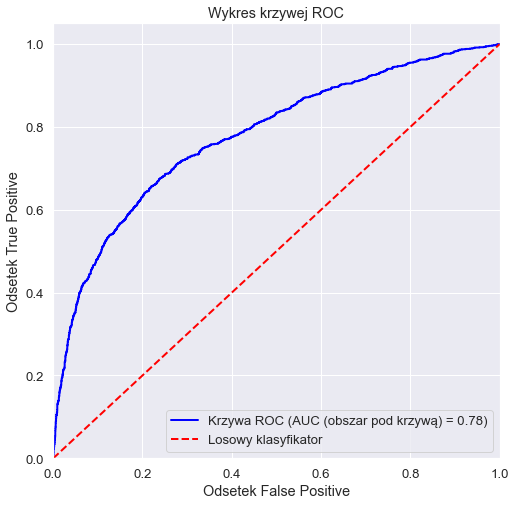

Pole pod krzywą ROC - AUC: 0.78
Współczynnik Giniego: 0.56


In [56]:
#Wywołanie funkcji do oceny modelu XGBoost
ocena_modelu(y_vali, y_pred_xgb[:, 1])


Wykres krzywej ROC dla zbudowanego modelu jest znacznie oddalony od linii losowego klasyfikatora i praktycznie identyczny jak dla modelu
z regresją logistyczną.<br>
Wyznaczona wartość pola pod krzywą ROC - AUC oraz współczynnik Giniego są trochę lepsze niż dla modelu podstawowego

<a class="anchor" id="model_fin_xgb"></a>
## Finalna weryfikacja jakości modelu
[Powrót do spisu treści](#toc)

Finalna weryfikacja modelu została przeprowadzona na zbiorze danych testowych, przy uwzględnieniu w modelowaniu  wybranych na wcześniejszym etapie atrybutów.

<a class="anchor" id="budowa_fin_xgb"></a>
### Model finalny

In [57]:
model_xgb_fin = XGBClassifier(**wybrane_parametry_xgb) #wykonanie modelu dla danych uczących
model_xgb_fin.fit(x_train[atrybuty_wybrane], y_train.values.ravel())
y_pred_xgb_fin = model_xgb.predict_proba(x_test[atrybuty_wybrane])#wykonanie predykcji dla danych walidacyjnych

<a class="anchor" id="ocena_fin_xgb"></a>
### Ocena modelu dla zbioru testowego

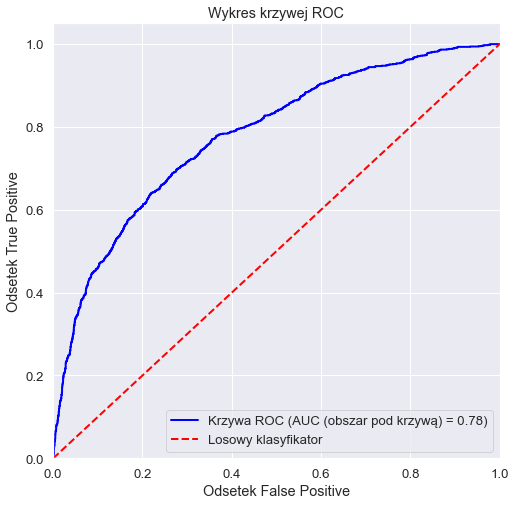

Pole pod krzywą ROC - AUC: 0.78
Współczynnik Giniego: 0.56


In [58]:
#Wywołanie funkcji do oceny modelu XGB
ocena_modelu(y_test, y_pred_xgb_fin[:, 1])

Finalny model klasyfikatora dla zbioru testowego identyczne parametry jakości w porównaniu do wartości ze zbioru walidacyjnego  Wyniki dla zbioru testowego nie odbiegają od wyników dla zbioru walidacyjnego więc model można uznać za nieprzetrenowany.


<a class="anchor" id="punkt_xgb"></a>
### Wyznaczanie optymalnego punktu odcięcia

In [59]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 50
punkt_odciecia_fin_xgb, max_dochod_xgb, dochody_xgb = punkt_odciecia(y_test, y_pred_xgb_fin[:, 1], 15, 50)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.'
          .format(max_dochod_xgb, punkt_odciecia_fin_xgb))

Największy dochód wynosi: 24305, któremu odpowiada punkt odcięcia: 0.2.


<a class="anchor" id="ocena_punkt_xgb"></a>
### Ocena klasyfikatora z uwzględnieniem  optymalnego punktu odcięcia
 Dla obliczonej wartości punktu odcięcia wyznaczono wskaźniki jakości modelu oraz macierz pomyłek.

### Macierz pomyłek i wskaźniki klasyfikacji

|  | Prognozowane "0"  | Prognozowane "1"  
------------ | ------------- | -------------
Prawdziwe "0" | TN | FP
Prawdziwe "1" | FN | TP

In [60]:
#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = \
            wskazniki_modelu(y_test, y_pred_xgb_fin[:, 1], punkt_odciecia_fin_xgb)

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      3933
           1       0.44      0.69      0.54      1208

    accuracy                           0.72      5141
   macro avg       0.66      0.71      0.67      5141
weighted avg       0.78      0.72      0.74      5141

Dokładność: 0.72
Błąd: 0.28
Specyficzność: 0.73
Czułość: 0.69
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              2867              1066
Prawdziwe "1"               374               834


<a class="anchor" id="rentownosc_xgb"></a>
### Podsumowanie wyników i wyznaczenie rentowności
Rentowność klasyfikatora obliczana jest z uwzględnieniem optymalnego punktu odcięcia

In [61]:
#Założone wartości zysku i straty
zysk = 15
strata = 50

print('Dla założonych zysku {} i straty {} otrzymano: \n'.format(zysk,strata))
print('Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))
print('Wartość uzyskanego dochodu:', max_dochod_xgb)
print('Ilość badanych klientów:', tn + fn + fp + tp)
print('Ilość klientów sklasyfikowanych jako wiarygodnych:', tn + fn)
print('Ilość klientów sklasyfikowanych jako niewiarygodnych:', fp + tp)
print('Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych:', tn)
print('Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych:', fn)
print('Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', fp)
print('Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', tp)

Dla założonych zysku 15 i straty 50 otrzymano: 

Rentowność: 7.5%
Wartość uzyskanego dochodu: 24305
Ilość badanych klientów: 5141
Ilość klientów sklasyfikowanych jako wiarygodnych: 3241
Ilość klientów sklasyfikowanych jako niewiarygodnych: 1900
Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych: 2867
Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych: 374
Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 1066
Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 834


Na podstawie przeprowadzonej analizy wykonanego modelu można stwierdzić, że wyniki są praktycznie identyczne jak dla modelu z regresją logistyczną. Uzyskana rentowność i łączny dochód są nieznacznie lepsze dla modelu XBGBoost. Model na podstawie algorytmu XGBoost bardzo podobnie do modelu podstawowego klasyfikuje klientów, choć uzyskuje nieznacznie więcej klientów niewiarygodnych. Wyznaczone dokładność, specyficzność i czułość są praktycznie identyczne. 
 

<a class="anchor" id="inne_doch_xgb"></a>
### Wyznaczenie dochodów dla innych zysków i strat dla modelu na podstawie XGBoost

In [62]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 75
punkt_odciecia_fin_xgb_15_75, max_dochod_xgb_15_75, dochody_xgb_15_75 = punkt_odciecia(y_test, y_pred_xgb_fin[:, 1], 15, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_xgb_15_75, punkt_odciecia_fin_xgb_15_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_xgb_fin[:, 1], punkt_odciecia_fin_xgb_15_75)

#Założone wartości zysku i straty
zysk = 15
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 17130, któremu odpowiada punkt odcięcia: 0.17.

              precision    recall  f1-score   support

           0       0.90      0.64      0.75      3933
           1       0.40      0.77      0.53      1208

    accuracy                           0.67      5141
   macro avg       0.65      0.71      0.64      5141
weighted avg       0.78      0.67      0.70      5141

Dokładność: 0.67
Błąd: 0.33
Specyficzność: 0.64
Czułość: 0.77
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              2532              1401
Prawdziwe "1"               278               930

 Rentowność: 6.1%


In [63]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 10 i straty równej 75
punkt_odciecia_fin_xgb_10_75, max_dochod_xgb_10_75, dochody_xgb_10_75 = punkt_odciecia(y_test, y_pred_xgb_fin[:, 1], 10, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_xgb_10_75, punkt_odciecia_fin_xgb_10_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_xgb_fin[:, 1], punkt_odciecia_fin_xgb_10_75)

#Założone wartości zysku i straty
zysk = 15
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 6820, któremu odpowiada punkt odcięcia: 0.12.

              precision    recall  f1-score   support

           0       0.93      0.39      0.55      3933
           1       0.31      0.91      0.47      1208

    accuracy                           0.51      5141
   macro avg       0.62      0.65      0.51      5141
weighted avg       0.79      0.51      0.53      5141

Dokładność: 0.51
Błąd: 0.49
Specyficzność: 0.39
Czułość: 0.91
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              1537              2396
Prawdziwe "1"               114              1094

 Rentowność: 8.79%


<a class="anchor" id="porownanie_doch"></a>
## Porównanie dochodów osiąganych przez modele na podstawie regresji logistycznej i XGBoost
[Powrót do spisu treści](#toc)

W celu porównania osiąganych wyników przez zbudowane modele zostały wykonane krzywe dochodów w zależności od punktów odcięcia.
Dodatkowo zostały dodane krzywe dochodów przy zmienionych wartościach zysku i straty. 

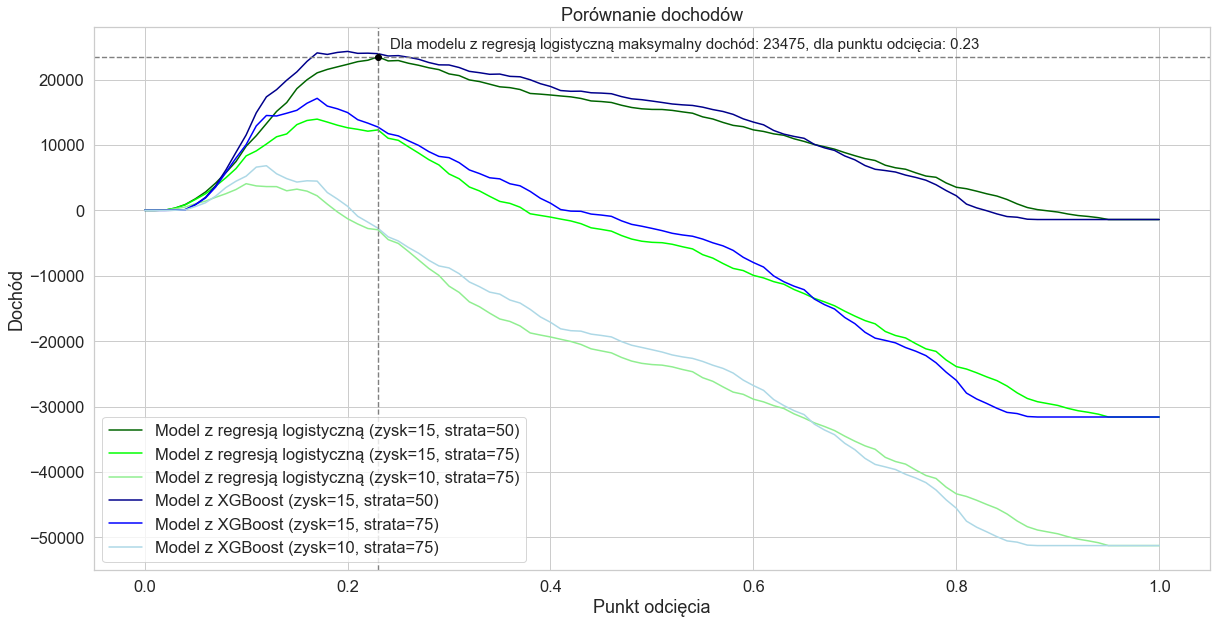

In [64]:
punkty_odciecia = np.arange(0, 1.01, 0.01)
sns.set(font_scale=1.5, style="whitegrid")

plt.figure(figsize = (20, 10))
ax_1 = sns.lineplot(x = punkty_odciecia, y = dochody_rl, color = 'darkgreen',label='Model z regresją logistyczną (zysk=15, strata=50)')
ax_1 = sns.lineplot(x = punkty_odciecia, y = dochody_rl_15_75, color = 'lime',label='Model z regresją logistyczną (zysk=15, strata=75)')
ax_1 = sns.lineplot(x = punkty_odciecia, y = dochody_rl_10_75, color = 'lightgreen',label='Model z regresją logistyczną (zysk=10, strata=75)')
ax_1 = sns.lineplot(x = punkty_odciecia, y = dochody_xgb, color = 'darkblue',label='Model z XGBoost (zysk=15, strata=50)')
ax_1 = sns.lineplot(x = punkty_odciecia, y = dochody_xgb_15_75, color = 'blue',label='Model z XGBoost (zysk=15, strata=75)')
ax_1 = sns.lineplot(x = punkty_odciecia, y = dochody_xgb_10_75, color = 'lightblue',label='Model z XGBoost (zysk=10, strata=75)')

#Narysowanie lini punktu odcięcia i maks. dochodu
ax_1.axvline(punkt_odciecia_fin, linestyle = '--', color = 'grey', linewidth = 1.4)
ax_1.axhline(max_dochod, linestyle = '--', color = 'grey', linewidth = 1.4)

txt=('Dla modelu z regresją logistyczną maksymalny dochód: {}, dla punktu odcięcia: {}'.format(max_dochod,punkt_odciecia_fin))
plt.text(punkt_odciecia_fin*1.05, max_dochod*1.08, txt, horizontalalignment='left', 
         verticalalignment='center', fontsize=15);
ax_1.plot(punkt_odciecia_fin, max_dochod, "or", color = 'black')


ax_1.set_xlabel('Punkt odcięcia')
ax_1.set_ylabel('Dochód')
plt.title('Porównanie dochodów')
plt.show()

        

Na podstawie powyższych wykresów można stwierdzić, że uzyskiwane dochody są bardzo podobne dla obu zbudowanych modeli. Dodatkowo na podstawie wykresu oraz przeprowadzonych testów należy dodać, że na rzeczywisty wynik bardzo duży wpływ będą miały realne wartości zysku i straty. Dla przykładu w modelu z regresją logistyczną założono, że bankowi nie udałoby się odzyskać połowy wartości kredytu (źle przeprowadzony proces windykacji) i strata wyniosłaby 75%. Spowodowałoby to zmniejszenie wartości rentowność z 6.7% do 5.31% oraz dochodu maksymalnego z 23475 do 13950.
Dodatkowo dla zmiany zysku z 15% na 10% co prawda rentowność wyniosłaby 4.48%, ale dochód równy 4075 byłby na tyle mały, że cała działalność mogłaby być nieopłacalna. 

<a class="anchor" id="podsumowanie"></a>
## Podsumowanie i wnioski
[Powrót do spisu treści](#toc)

Podsumowując udało się zbudować model, który pozwala na wyznaczenie
niewypłacalności klientów w przyszłym miesiącu z uwzględnieniem założeń biznesowych tj. maksymalizowania uzyskanego dochodu przez bank z całego portfela kredytowego.
Zbudowany model na bazie algorytmu regresji logistycznej daje dobre rezultaty zarówno jeśli chodzi o parametry jakości modelu jak również rentowność procesu przyznawania kredytów, biorąc pod uwagę cały portfel kredytowy. Uzyskana rentowność (średni dochód na łączną ilość udzielonych kredytów) jest dobra i wynosi 6.7%. Łączny dochód wyniósł 23475 (gdzie 100 oznacza uśrednioną wartość przyznanego kredytu).<br>
Wykonany do porównania osiąganych wyników model oparty o algorytm XGBoost uzyskiwał bardzo podobne wyniki jak model podstawowy. Biorąc pod uwagę ograniczenie związane z wykorzystaniem algorytmów w pełni interpretowalnych w procesie przyznawania kredytów możliwe jest zatem stosowanie algorytmu regresji logistycznej bez znaczącego spadku skuteczności modelu. Dla jakości modelu bardziej istotne niż wybór rodzaju algorytmu okazało się przygotowanie danych oraz wybór właściwych atrybutów.

W celu dokładnej oceny jakości modelu przed zastosowaniem w rzeczywistych warunkach należałoby jeszcze wykonać sprawdzenie modelu dodatkowym zestawem danych, który powinien zawierać obserwacje z innego okresu niż obserwacje widoczne w badanym zbiorze danych. Dodatkowo dla poprawy wyników można by zastosować jeszcze inny typ 
algorytmu do zbudowania modelu np. algorytm drzewa decyzyjnego i przeprowadzić weryfikacje osiągniętych wyników. Prawdopodobnie zastosowanie dodatkowych transformacji wartości atrybutów lub poprawienie doboru parametrów miałoby korzystny wpływ na poprawienie skuteczności modelu, ale mogłoby też mieć wpływ na interpretowalność modelu.
 

<a class="anchor" id="modele_dodatkowe"></a>
# Dodatkowe modele
[Powrót do spisu treści](#toc)

<a class="anchor" id="model_tree"></a>
## Model Drzewo decyzyjne
[Powrót do spisu treści](#toc)

<a class="anchor" id="hiperparametry_tree"></a>
### Optymalizacja hiperparametrów modelu
Przed przystąpieniem do budowy modelu został przeprowadzony dobór hiperparamterów z zastosowaniem metody losowego doboru przy pomocy funkcji RandomizedSearchCV.

In [65]:
#określenie zakresów możliwych wartości hiperparametrów
parametry_tree = {'criterion':('entropy', 'gini'),
'splitter':('best','random'),
'max_depth':randint(1,6),
'min_samples_split':randint(3,8),
'min_samples_leaf':randint(1,5)}

In [66]:
#po jednym wyznaczeniu najlepszych parametrów zaznaczenie poniższego kodu żeby się nie wykonywał bo trwa to długo
'''
def losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):

    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)
    rs.fit(x, y.values.ravel())
    wybrane_parametry = rs.best_params_
    return wybrane_parametry;
    

wybrane_parametry_tree = losowa_optymalizacja_hp(x_train, y_train, parametry_tree, DecisionTreeClassifier(), n_iter=20, n_jobs = 2, cv = 10)
wybrane_parametry_tree
'''

'\ndef losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):\n\n    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)\n    rs.fit(x, y.values.ravel())\n    wybrane_parametry = rs.best_params_\n    return wybrane_parametry;\n    \n\nwybrane_parametry_tree = losowa_optymalizacja_hp(x_train, y_train, parametry_tree, DecisionTreeClassifier(), n_iter=20, n_jobs = 2, cv = 10)\nwybrane_parametry_tree\n'

In [67]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#1 zestaw

wybrane_parametry_tree1 = {'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'splitter': 'random'}


In [68]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#2 zestaw

wybrane_parametry_tree2 = {'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'splitter': 'best'}


In [69]:
#wybór odpowiedniego zestawu hiperparametrów dla modelu

wybrane_parametry_tree=wybrane_parametry_tree1

<a class="anchor" id="budowa"></a>
### Budowa modelu

Do wykonania modelu została wykorzystany algorytm drzewa decyzyjnego z biblioteki *sklearn.tree*.


In [70]:
model = DecisionTreeClassifier(**wybrane_parametry_tree)
#wykonanie modelu dla danych uczących, przy użyciu walidacji krzyżowej w celu uniknięcia przetrenowania modelu
cv = cross_val_score(model, x_train, y_train, cv = 10, scoring = 'accuracy') 

print('Średnie dokładność: ' + str(cv.mean().round(3)))
print('Stabilność: ' + str((cv.std()*100/cv.mean()).round(3)) + '%')

Średnie dokładność: 0.81
Stabilność: 0.948%


In [71]:
model.fit(x_train[atrybuty_wybrane], y_train)
y_pred = model.predict(x_vali[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych

<a class="anchor" id="ocena"></a>
### Ocena modelu dla zbioru walidacyjnego

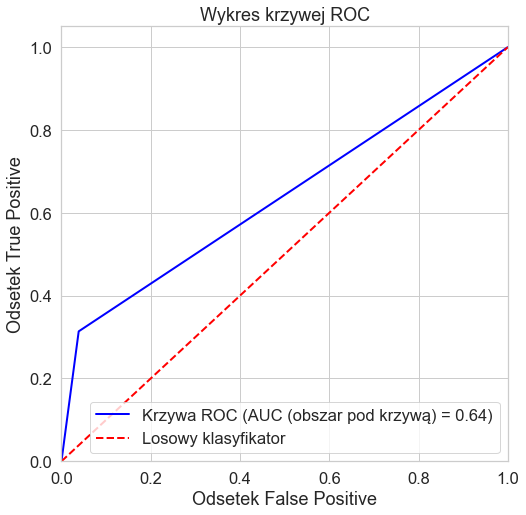

Pole pod krzywą ROC - AUC: 0.64
Współczynnik Giniego: 0.28


In [72]:
#Wywołanie funkcji do oceny modelu  
ocena_modelu(y_vali, y_pred)


Wykres Krzywej ROC jest najbardziej oddalony od lini losowego klasyfikatora w początkowym fragmencie i osiąga maksimum około pierwszej ćwiartki wykresu. Wskazuje to, że szukany optymalny punkt odcięcia (wyznaczony w kolejnym etapie) będzie znajdował się w tym obszarze.<br>
Wartość AUC oraz współczynnika Giniego są akceptowalne, choć ich wartości nie są bardzo duże.

<a class="anchor" id="model_fin"></a>
## Finalna weryfikacja jakości modelu
[Powrót do spisu treści](#toc)

Finalna weryfikacja modelu została przeprowadzona na zbiorze danych testowych, przy uwzględnieniu w modelowaniu  wybranych na wcześniejszym etapie atrybutów.

<a class="anchor" id="budowa_fin"></a>
### Model finalny

In [73]:
y_pred_fin = model.predict(x_test[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych

<a class="anchor" id="ocena_fin"></a>
### Ocena modelu dla zbioru testowego

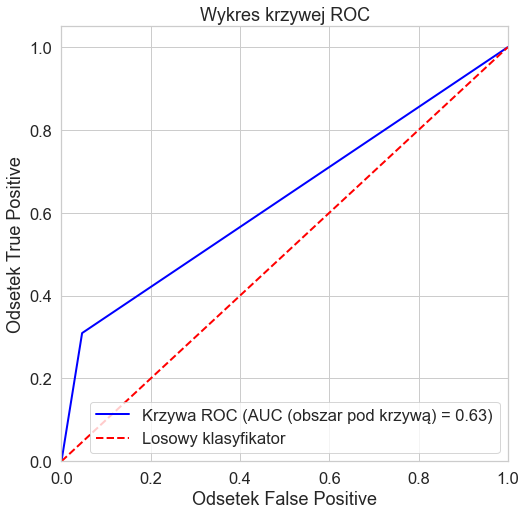

Pole pod krzywą ROC - AUC: 0.63
Współczynnik Giniego: 0.26


In [74]:
ocena_modelu(y_test, y_pred_fin)

Jak widać finalny model klasyfikatora ma prawie identyczne parametry jakości w porównaniu do wartości ze zbioru walidacyjnego i moża je uznać za zadawalające. Wyniki dla zbioru testowego nie odbiegają od wyników dla zbioru walidacyjnego więc model można uznać za nieprzetrenowany i powinien uzyskiwać podobne wyniki na rzeczywistych danych.

<a class="anchor" id="punkt"></a>
### Wyznaczanie optymalnego punktu odcięcia

In [75]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 50
punkt_odciecia_fin, max_dochod, dochody = punkt_odciecia(y_test, y_pred_fin, 15, 50)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.'
          .format(max_dochod, punkt_odciecia_fin))

Największy dochód wynosi: 14565, któremu odpowiada punkt odcięcia: 0.0.


<a class="anchor" id="ocena_punkt"></a>
### Ocena klasyfikatora z uwzględnieniem  optymalnego punktu odcięcia
 Dla obliczonej wartości punktu odcięcia wyznaczono wskaźniki jakości modelu oraz macierz pomyłek.

In [76]:
#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3933
           1       0.67      0.31      0.42      1208

    accuracy                           0.80      5141
   macro avg       0.75      0.63      0.65      5141
weighted avg       0.78      0.80      0.77      5141

Dokładność: 0.8
Błąd: 0.2
Specyficzność: 0.95
Czułość: 0.31
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              3751               182
Prawdziwe "1"               834               374


<a class="anchor" id="rentownosc"></a>
### Podsumowanie wyników i wyznaczenie rentowności
Rentowność klasyfikatora obliczana jest z uwzględnieniem optymalnego punktu odcięcia

In [77]:
#Założone wartości zysku i straty
zysk = 15
strata = 50

print('Dla założonych zysku {} i straty {} otrzymano: \n'.format(zysk,strata))
print('- Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))
print('- Wartość uzyskanego dochodu: ', max_dochod)

print('- Ilość badanych klientów:', tn + fn + fp + tp)
print('- Ilość klientów sklasyfikowanych jako wiarygodnych:', tn + fn)
print('- Ilość klientów sklasyfikowanych jako niewiarygodnych:', fp + tp)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych:', tn)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych:', fn)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', fp)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', tp)

Dla założonych zysku 15 i straty 50 otrzymano: 

- Rentowność: 3.18%
- Wartość uzyskanego dochodu:  14565
- Ilość badanych klientów: 5141
- Ilość klientów sklasyfikowanych jako wiarygodnych: 4585
- Ilość klientów sklasyfikowanych jako niewiarygodnych: 556
- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych: 3751
- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych: 834
- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 182
- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 374


<font color='red'>
Na podstawie przeprowadzonej analizy wykonanego modelu można stwierdzić, że jakość modelu biorąc pod uwagę uzyskany dochód z całego portfela kredytów jest satysfakcjonujący. 
 </font>

<a class="anchor" id="inne_doch"></a>
### Wyznaczenie dochodów dla innych zysków i strat dla modelu

In [78]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 75
punkt_odciecia_fin_tree_15_75, max_dochod_tree_15_75, dochody_tree_15_75 = punkt_odciecia(y_test, y_pred_fin, 15, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_tree_15_75, punkt_odciecia_fin_tree_15_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_tree_15_75)

#Założone wartości zysku i straty
zysk = 15
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: -6285, któremu odpowiada punkt odcięcia: 0.0.

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3933
           1       0.67      0.31      0.42      1208

    accuracy                           0.80      5141
   macro avg       0.75      0.63      0.65      5141
weighted avg       0.78      0.80      0.77      5141

Dokładność: 0.8
Błąd: 0.2
Specyficzność: 0.95
Czułość: 0.31
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              3751               182
Prawdziwe "1"               834               374

 Rentowność: -1.37%


In [79]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 10 i straty równej 75
punkt_odciecia_fin_tree_10_75, max_dochod_tree_10_75, dochody_tree_10_75 = punkt_odciecia(y_test, y_pred_fin, 10, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_tree_10_75, punkt_odciecia_fin_tree_10_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_tree_10_75)

#Założone wartości zysku i straty
zysk = 10
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: -25040, któremu odpowiada punkt odcięcia: 0.0.

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3933
           1       0.67      0.31      0.42      1208

    accuracy                           0.80      5141
   macro avg       0.75      0.63      0.65      5141
weighted avg       0.78      0.80      0.77      5141

Dokładność: 0.8
Błąd: 0.2
Specyficzność: 0.95
Czułość: 0.31
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              3751               182
Prawdziwe "1"               834               374

 Rentowność: -5.46%


<a class="anchor" id="model_light"></a>
## Model LightGBM
[Powrót do spisu treści](#toc)

<a class="anchor" id="hiperparametry_tree"></a>
### Optymalizacja hiperparametrów modelu
Przed przystąpieniem do budowy modelu został przeprowadzony dobór hiperparamterów z zastosowaniem metody losowego doboru przy pomocy funkcji RandomizedSearchCV.

In [80]:
#określenie zakresów możliwych wartości hiperparametrów
parametry_lgb = {
    'n_estimators' : randint(50, 500),
    'max_depth' : randint(2, 10),
    'learning_rate' : uniform(loc = 0, scale = 1),
    'min_child_weight' : randint(1, 5),
    'subsample': uniform(loc = 0, scale = 1),
    'colsample_bytree': uniform(loc = 0, scale = 1),
    'reg_alpha' : uniform(loc = 0, scale = 1),
    'reg_lambda' : uniform(loc = 0, scale = 1),    
    'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
    'n_jobs' : [2]
}

In [81]:
#po jednym wyznaczeniu najlepszych parametrów zaznaczenie poniższego kodu żeby się nie wykonywał bo trwa to długo
'''
def losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):

    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)
    rs.fit(x, y.values.ravel())
    wybrane_parametry = rs.best_params_
    return wybrane_parametry;
    

wybrane_parametry_lgb = losowa_optymalizacja_hp(x_train, y_train, parametry_lgb, lgb.LGBMClassifier(), n_iter=20, n_jobs = 2, cv = 5)
wybrane_parametry_lgb
'''

'\ndef losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):\n\n    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)\n    rs.fit(x, y.values.ravel())\n    wybrane_parametry = rs.best_params_\n    return wybrane_parametry;\n    \n\nwybrane_parametry_lgb = losowa_optymalizacja_hp(x_train, y_train, parametry_lgb, lgb.LGBMClassifier(), n_iter=20, n_jobs = 2, cv = 5)\nwybrane_parametry_lgb\n'

In [82]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#1 zestaw

wybrane_parametry_lgb1 = {'boosting_type': 'dart',
 'colsample_bytree': 0.6788167768558275,
 'learning_rate': 0.23796503105661648,
 'max_depth': 2,
 'min_child_weight': 3,
 'n_estimators': 258,
 'n_jobs': 2,
 'reg_alpha': 0.2350667112299657,
 'reg_lambda': 0.4612776047061984,
 'subsample': 0.2632261204502928}


In [83]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#2 zestaw

wybrane_parametry_lgb2 = {'boosting_type': 'dart',
 'colsample_bytree': 0.7744419993090215,
 'learning_rate': 0.07368636063550338,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 489,
 'n_jobs': 2,
 'reg_alpha': 0.9996185067696776,
 'reg_lambda': 0.0977974819384233,
 'subsample': 0.6327500540960664}


In [84]:
#wybór odpowiedniego zestawu hiperparametrów dla modelu

wybrane_parametry_lgb = wybrane_parametry_lgb1

<a class="anchor" id="budowa"></a>
### Budowa modelu

Do wykonania modelu została wykorzystany algorytm LightGBM.


In [85]:
model = lgb.LGBMClassifier(**wybrane_parametry_lgb) #wykonanie modelu dla danych uczących
model.fit(x_train[atrybuty_wybrane], y_train.values.ravel())
y_pred = model.predict_proba(x_vali[atrybuty_wybrane])#sprawdzenie modelu dla danych walidacyjnych
y_pred = y_pred[:, 1] #przepisanie tylko kolumny z danymi zmiennej celu

<a class="anchor" id="ocena"></a>
### Ocena modelu dla zbioru walidacyjnego

In [86]:
#ocena istotności atrybutów
pd.DataFrame(model.feature_importances_, index = x_train[atrybuty_wybrane].columns)\
                                                        .sort_values(by = 0, ascending = False)

,0
splata_wrz_bin,118
wyciag_wrz,101
splata_sie,61
limit_kredytu_bin,49
splata_wrz,45
splata_lip,30
platnosc_sie,28
wyciag_lip,26
wiek,26
wyciag_kwi,24


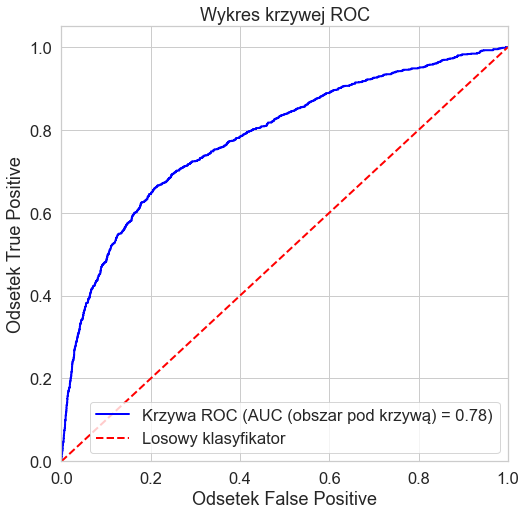

Pole pod krzywą ROC - AUC: 0.78
Współczynnik Giniego: 0.56


In [87]:
#Wywołanie funkcji do oceny modelu  
ocena_modelu(y_vali, y_pred)


Wykres Krzywej ROC jest najbardziej oddalony od lini losowego klasyfikatora w początkowym fragmencie i osiąga maksimum około pierwszej ćwiartki wykresu. Wskazuje to, że szukany optymalny punkt odcięcia (wyznaczony w kolejnym etapie) będzie znajdował się w tym obszarze.<br>
Wartość AUC oraz współczynnika Giniego są akceptowalne, choć ich wartości nie są bardzo duże.

<a class="anchor" id="model_fin"></a>
## Finalna weryfikacja jakości modelu
[Powrót do spisu treści](#toc)

Finalna weryfikacja modelu została przeprowadzona na zbiorze danych testowych, przy uwzględnieniu w modelowaniu  wybranych na wcześniejszym etapie atrybutów.

<a class="anchor" id="budowa_fin"></a>
### Model finalny

In [88]:
y_pred_fin = model.predict_proba(x_test[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych
y_pred_fin = y_pred_fin[:, 1] #przepisanie tylko kolumny z danymi zmiennej celu

<a class="anchor" id="ocena_fin"></a>
### Ocena modelu dla zbioru testowego

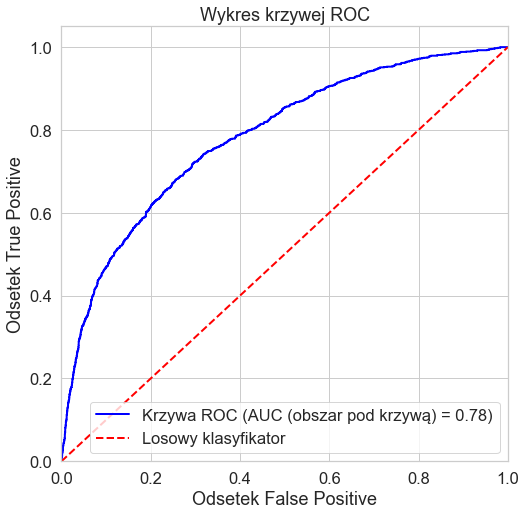

Pole pod krzywą ROC - AUC: 0.78
Współczynnik Giniego: 0.56


In [89]:
ocena_modelu(y_test, y_pred_fin)

Jak widać finalny model klasyfikatora ma prawie identyczne parametry jakości w porównaniu do wartości ze zbioru walidacyjnego i moża je uznać za zadawalające. Wyniki dla zbioru testowego nie odbiegają od wyników dla zbioru walidacyjnego więc model można uznać za nieprzetrenowany i powinien uzyskiwać podobne wyniki na rzeczywistych danych.

<a class="anchor" id="punkt"></a>
### Wyznaczanie optymalnego punktu odcięcia

In [90]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 50
punkt_odciecia_fin, max_dochod, dochody = punkt_odciecia(y_test, y_pred_fin, 15, 50)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.'
          .format(max_dochod, punkt_odciecia_fin))

Największy dochód wynosi: 24655, któremu odpowiada punkt odcięcia: 0.19.


<a class="anchor" id="ocena_punkt"></a>
### Ocena klasyfikatora z uwzględnieniem  optymalnego punktu odcięcia
 Dla obliczonej wartości punktu odcięcia wyznaczono wskaźniki jakości modelu oraz macierz pomyłek.

In [91]:
#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin)

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      3933
           1       0.43      0.72      0.54      1208

    accuracy                           0.71      5141
   macro avg       0.66      0.71      0.66      5141
weighted avg       0.78      0.71      0.73      5141

Dokładność: 0.71
Błąd: 0.29
Specyficzność: 0.71
Czułość: 0.72
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              2777              1156
Prawdziwe "1"               340               868


<a class="anchor" id="rentownosc"></a>
### Podsumowanie wyników i wyznaczenie rentowności
Rentowność klasyfikatora obliczana jest z uwzględnieniem optymalnego punktu odcięcia

In [92]:
#Założone wartości zysku i straty
zysk = 15
strata = 50

print('Dla założonych zysku {} i straty {} otrzymano: \n'.format(zysk,strata))
print('- Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))
print('- Wartość uzyskanego dochodu: ', max_dochod)

print('- Ilość badanych klientów:', tn + fn + fp + tp)
print('- Ilość klientów sklasyfikowanych jako wiarygodnych:', tn + fn)
print('- Ilość klientów sklasyfikowanych jako niewiarygodnych:', fp + tp)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych:', tn)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych:', fn)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', fp)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', tp)

Dla założonych zysku 15 i straty 50 otrzymano: 

- Rentowność: 7.91%
- Wartość uzyskanego dochodu:  24655
- Ilość badanych klientów: 5141
- Ilość klientów sklasyfikowanych jako wiarygodnych: 3117
- Ilość klientów sklasyfikowanych jako niewiarygodnych: 2024
- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych: 2777
- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych: 340
- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 1156
- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 868


<font color='red'>
Na podstawie przeprowadzonej analizy wykonanego modelu można stwierdzić, że jakość modelu biorąc pod uwagę uzyskany dochód z całego portfela kredytów jest satysfakcjonujący. 
 </font>

<a class="anchor" id="inne_doch"></a>
### Wyznaczenie dochodów dla innych zysków i strat dla modelu

In [93]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 75
punkt_odciecia_fin_lgb_15_75, max_dochod_lgb_15_75, dochody_lgb_15_75 = punkt_odciecia(y_test, y_pred_fin, 15, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_lgb_15_75, punkt_odciecia_fin_lgb_15_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_lgb_15_75)

#Założone wartości zysku i straty
zysk = 15
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 16770, któremu odpowiada punkt odcięcia: 0.18.

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      3933
           1       0.42      0.74      0.53      1208

    accuracy                           0.69      5141
   macro avg       0.66      0.71      0.65      5141
weighted avg       0.78      0.69      0.72      5141

Dokładność: 0.69
Błąd: 0.31
Specyficzność: 0.68
Czułość: 0.74
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              2673              1260
Prawdziwe "1"               311               897

 Rentowność: 5.62%


In [94]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 10 i straty równej 75
punkt_odciecia_fin_lgb_10_75, max_dochod_lgb_10_75, dochody_lgb_10_75 = punkt_odciecia(y_test, y_pred_fin, 10, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_lgb_10_75, punkt_odciecia_fin_lgb_10_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_lgb_10_75)

#Założone wartości zysku i straty
zysk = 10
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 7200, któremu odpowiada punkt odcięcia: 0.12.

              precision    recall  f1-score   support

           0       0.93      0.40      0.56      3933
           1       0.32      0.91      0.47      1208

    accuracy                           0.52      5141
   macro avg       0.62      0.65      0.51      5141
weighted avg       0.79      0.52      0.54      5141

Dokładność: 0.52
Błąd: 0.48
Specyficzność: 0.4
Czułość: 0.91
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              1575              2358
Prawdziwe "1"               114              1094

 Rentowność: 4.26%


<a class="anchor" id="model_cat"></a>
## Model CATBoost
[Powrót do spisu treści](#toc)

<a class="anchor" id="hiperparametry_tree"></a>
### Optymalizacja hiperparametrów modelu
Przed przystąpieniem do budowy modelu został przeprowadzony dobór hiperparamterów z zastosowaniem metody losowego doboru przy pomocy funkcji RandomizedSearchCV.

In [95]:
#określenie zakresów możliwych wartości hiperparametrów
parametry_cat = {
    'n_estimators' : randint(50, 500),
    'max_depth' : randint(2, 10),
    'learning_rate' : uniform(loc = 0, scale = 1),
    'subsample': uniform(loc = 0, scale = 1),
    'reg_lambda' : uniform(loc = 0, scale = 1),    
    'boosting_type' : ['gbdt', 'dart', 'goss', 'rf']
}

In [96]:
#po jednym wyznaczeniu najlepszych parametrów zaznaczenie poniższego kodu żeby się nie wykonywał bo trwa to długo
'''
def losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):

    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)
    rs.fit(x, y.values.ravel())
    wybrane_parametry = rs.best_params_
    return wybrane_parametry;
    

wybrane_parametry_cat = losowa_optymalizacja_hp(x_train, y_train, parametry_cat, CatBoostClassifier(), n_iter=20, n_jobs = 2, cv = 5)
wybrane_parametry_cat
'''

'\ndef losowa_optymalizacja_hp(x, y, hiperparametry, model, n_iter=20, n_jobs = 2, cv = 5):\n\n    rs = RandomizedSearchCV(model, hiperparametry, n_iter = n_iter, n_jobs = n_jobs, cv = cv)\n    rs.fit(x, y.values.ravel())\n    wybrane_parametry = rs.best_params_\n    return wybrane_parametry;\n    \n\nwybrane_parametry_cat = losowa_optymalizacja_hp(x_train, y_train, parametry_cat, CatBoostClassifier(), n_iter=20, n_jobs = 2, cv = 5)\nwybrane_parametry_cat\n'

In [97]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#1 zestaw

wybrane_parametry_cat1 = {
 'learning_rate': 0.23796503105661648,
 'max_depth': 2,
 'n_estimators': 258,
 'reg_lambda': 0.4612776047061984,
 'subsample': 0.2632261204502928}


In [98]:
#po jednym wyznaczeniu najlepszych parametrów przypisanie na stałe bo generowanie trwa długo
#2 zestaw

wybrane_parametry_cat2 = {
 'learning_rate': 0.07368636063550338,
 'max_depth': 8,
 'n_estimators': 489,
 'reg_lambda': 0.0977974819384233,
 'subsample': 0.6327500540960664}


In [99]:
#wybór odpowiedniego zestawu hiperparametrów dla modelu

wybrane_parametry_cat = wybrane_parametry_cat1

<a class="anchor" id="budowa"></a>
### Budowa modelu

Do wykonania modelu została wykorzystany algorytm LightGBM.


In [100]:
model = CatBoostClassifier() #wykonanie modelu dla danych uczących
model.fit(x_train[atrybuty_wybrane], y_train.values.ravel())
y_pred = model.predict_proba(x_vali[atrybuty_wybrane])#sprawdzenie modelu dla danych walidacyjnych
y_pred = y_pred[:, 1] #przepisanie tylko kolumny z danymi zmiennej celu

Learning rate set to 0.033132
0:	learn: 0.6754169	total: 66.7ms	remaining: 1m 6s
1:	learn: 0.6589965	total: 76.7ms	remaining: 38.3s
2:	learn: 0.6443060	total: 88.1ms	remaining: 29.3s
3:	learn: 0.6295542	total: 100ms	remaining: 24.9s
4:	learn: 0.6164188	total: 110ms	remaining: 22s
5:	learn: 0.6040023	total: 125ms	remaining: 20.7s
6:	learn: 0.5926281	total: 137ms	remaining: 19.4s
7:	learn: 0.5822140	total: 151ms	remaining: 18.7s
8:	learn: 0.5722227	total: 165ms	remaining: 18.1s
9:	learn: 0.5629863	total: 176ms	remaining: 17.4s
10:	learn: 0.5545327	total: 192ms	remaining: 17.3s
11:	learn: 0.5470563	total: 205ms	remaining: 16.8s
12:	learn: 0.5400219	total: 218ms	remaining: 16.5s
13:	learn: 0.5333394	total: 229ms	remaining: 16.1s
14:	learn: 0.5271055	total: 239ms	remaining: 15.7s
15:	learn: 0.5213303	total: 249ms	remaining: 15.3s
16:	learn: 0.5161730	total: 261ms	remaining: 15.1s
17:	learn: 0.5112234	total: 272ms	remaining: 14.8s
18:	learn: 0.5068839	total: 287ms	remaining: 14.8s
19:	learn:

168:	learn: 0.4227065	total: 1.8s	remaining: 8.87s
169:	learn: 0.4225390	total: 1.81s	remaining: 8.86s
170:	learn: 0.4224500	total: 1.82s	remaining: 8.85s
171:	learn: 0.4223317	total: 1.83s	remaining: 8.83s
172:	learn: 0.4222077	total: 1.84s	remaining: 8.81s
173:	learn: 0.4221024	total: 1.85s	remaining: 8.79s
174:	learn: 0.4220467	total: 1.86s	remaining: 8.78s
175:	learn: 0.4219931	total: 1.87s	remaining: 8.76s
176:	learn: 0.4218534	total: 1.88s	remaining: 8.75s
177:	learn: 0.4216591	total: 1.89s	remaining: 8.73s
178:	learn: 0.4214415	total: 1.9s	remaining: 8.72s
179:	learn: 0.4212873	total: 1.91s	remaining: 8.7s
180:	learn: 0.4211830	total: 1.92s	remaining: 8.69s
181:	learn: 0.4210700	total: 1.93s	remaining: 8.67s
182:	learn: 0.4209392	total: 1.94s	remaining: 8.66s
183:	learn: 0.4208539	total: 1.95s	remaining: 8.65s
184:	learn: 0.4207886	total: 1.96s	remaining: 8.63s
185:	learn: 0.4206985	total: 1.97s	remaining: 8.64s
186:	learn: 0.4205738	total: 1.98s	remaining: 8.63s
187:	learn: 0.4

329:	learn: 0.4045472	total: 3.51s	remaining: 7.12s
330:	learn: 0.4043963	total: 3.52s	remaining: 7.11s
331:	learn: 0.4042942	total: 3.53s	remaining: 7.1s
332:	learn: 0.4041974	total: 3.54s	remaining: 7.09s
333:	learn: 0.4040157	total: 3.55s	remaining: 7.07s
334:	learn: 0.4039340	total: 3.56s	remaining: 7.06s
335:	learn: 0.4038288	total: 3.57s	remaining: 7.05s
336:	learn: 0.4037064	total: 3.58s	remaining: 7.04s
337:	learn: 0.4036620	total: 3.58s	remaining: 7.02s
338:	learn: 0.4035343	total: 3.59s	remaining: 7.01s
339:	learn: 0.4034148	total: 3.6s	remaining: 7s
340:	learn: 0.4033030	total: 3.61s	remaining: 6.98s
341:	learn: 0.4032050	total: 3.62s	remaining: 6.97s
342:	learn: 0.4030662	total: 3.63s	remaining: 6.96s
343:	learn: 0.4030087	total: 3.64s	remaining: 6.95s
344:	learn: 0.4028427	total: 3.65s	remaining: 6.93s
345:	learn: 0.4027238	total: 3.66s	remaining: 6.92s
346:	learn: 0.4025748	total: 3.67s	remaining: 6.91s
347:	learn: 0.4024478	total: 3.68s	remaining: 6.89s
348:	learn: 0.402

495:	learn: 0.3866473	total: 5.21s	remaining: 5.29s
496:	learn: 0.3865545	total: 5.22s	remaining: 5.28s
497:	learn: 0.3865067	total: 5.23s	remaining: 5.28s
498:	learn: 0.3864083	total: 5.24s	remaining: 5.26s
499:	learn: 0.3863410	total: 5.25s	remaining: 5.25s
500:	learn: 0.3862824	total: 5.26s	remaining: 5.24s
501:	learn: 0.3861566	total: 5.28s	remaining: 5.23s
502:	learn: 0.3860611	total: 5.29s	remaining: 5.22s
503:	learn: 0.3859827	total: 5.3s	remaining: 5.21s
504:	learn: 0.3859205	total: 5.31s	remaining: 5.2s
505:	learn: 0.3858686	total: 5.32s	remaining: 5.19s
506:	learn: 0.3857498	total: 5.33s	remaining: 5.18s
507:	learn: 0.3856156	total: 5.34s	remaining: 5.17s
508:	learn: 0.3854866	total: 5.35s	remaining: 5.16s
509:	learn: 0.3854148	total: 5.36s	remaining: 5.15s
510:	learn: 0.3853198	total: 5.37s	remaining: 5.14s
511:	learn: 0.3852042	total: 5.38s	remaining: 5.13s
512:	learn: 0.3851019	total: 5.39s	remaining: 5.12s
513:	learn: 0.3849720	total: 5.4s	remaining: 5.11s
514:	learn: 0.3

654:	learn: 0.3707159	total: 6.91s	remaining: 3.64s
655:	learn: 0.3706292	total: 6.92s	remaining: 3.63s
656:	learn: 0.3705357	total: 6.93s	remaining: 3.62s
657:	learn: 0.3704856	total: 6.94s	remaining: 3.61s
658:	learn: 0.3703611	total: 6.96s	remaining: 3.6s
659:	learn: 0.3702736	total: 6.96s	remaining: 3.59s
660:	learn: 0.3701458	total: 6.98s	remaining: 3.58s
661:	learn: 0.3699965	total: 6.99s	remaining: 3.57s
662:	learn: 0.3699019	total: 7s	remaining: 3.56s
663:	learn: 0.3697363	total: 7s	remaining: 3.54s
664:	learn: 0.3695657	total: 7.02s	remaining: 3.53s
665:	learn: 0.3694678	total: 7.03s	remaining: 3.52s
666:	learn: 0.3694082	total: 7.04s	remaining: 3.51s
667:	learn: 0.3692988	total: 7.04s	remaining: 3.5s
668:	learn: 0.3692206	total: 7.05s	remaining: 3.49s
669:	learn: 0.3691249	total: 7.06s	remaining: 3.48s
670:	learn: 0.3690112	total: 7.07s	remaining: 3.47s
671:	learn: 0.3689045	total: 7.08s	remaining: 3.46s
672:	learn: 0.3688451	total: 7.09s	remaining: 3.45s
673:	learn: 0.368732

815:	learn: 0.3561366	total: 8.71s	remaining: 1.96s
816:	learn: 0.3560515	total: 8.73s	remaining: 1.95s
817:	learn: 0.3559754	total: 8.74s	remaining: 1.94s
818:	learn: 0.3558669	total: 8.76s	remaining: 1.94s
819:	learn: 0.3557670	total: 8.77s	remaining: 1.93s
820:	learn: 0.3556461	total: 8.78s	remaining: 1.92s
821:	learn: 0.3555837	total: 8.79s	remaining: 1.9s
822:	learn: 0.3555002	total: 8.8s	remaining: 1.89s
823:	learn: 0.3553968	total: 8.82s	remaining: 1.88s
824:	learn: 0.3553093	total: 8.83s	remaining: 1.87s
825:	learn: 0.3552037	total: 8.84s	remaining: 1.86s
826:	learn: 0.3551446	total: 8.85s	remaining: 1.85s
827:	learn: 0.3550371	total: 8.86s	remaining: 1.84s
828:	learn: 0.3549481	total: 8.87s	remaining: 1.83s
829:	learn: 0.3548319	total: 8.88s	remaining: 1.82s
830:	learn: 0.3547647	total: 8.89s	remaining: 1.81s
831:	learn: 0.3547267	total: 8.9s	remaining: 1.8s
832:	learn: 0.3546217	total: 8.92s	remaining: 1.79s
833:	learn: 0.3545333	total: 8.93s	remaining: 1.78s
834:	learn: 0.35

976:	learn: 0.3425649	total: 10.6s	remaining: 249ms
977:	learn: 0.3424133	total: 10.6s	remaining: 238ms
978:	learn: 0.3423430	total: 10.6s	remaining: 228ms
979:	learn: 0.3422373	total: 10.6s	remaining: 217ms
980:	learn: 0.3421808	total: 10.6s	remaining: 206ms
981:	learn: 0.3421430	total: 10.6s	remaining: 195ms
982:	learn: 0.3420656	total: 10.7s	remaining: 184ms
983:	learn: 0.3419889	total: 10.7s	remaining: 173ms
984:	learn: 0.3419324	total: 10.7s	remaining: 163ms
985:	learn: 0.3417635	total: 10.7s	remaining: 152ms
986:	learn: 0.3416761	total: 10.7s	remaining: 141ms
987:	learn: 0.3416131	total: 10.7s	remaining: 130ms
988:	learn: 0.3415263	total: 10.7s	remaining: 119ms
989:	learn: 0.3414984	total: 10.7s	remaining: 108ms
990:	learn: 0.3414057	total: 10.8s	remaining: 97.6ms
991:	learn: 0.3413118	total: 10.8s	remaining: 86.8ms
992:	learn: 0.3412576	total: 10.8s	remaining: 75.9ms
993:	learn: 0.3411799	total: 10.8s	remaining: 65.1ms
994:	learn: 0.3411045	total: 10.8s	remaining: 54.2ms
995:	le

<a class="anchor" id="ocena"></a>
### Ocena modelu dla zbioru walidacyjnego

In [101]:
#ocena istotności atrybutów
pd.DataFrame(model.feature_importances_, index = x_train[atrybuty_wybrane].columns)\
                                                        .sort_values(by = 0, ascending = False)

,0
wyciag_wrz,7.992651
splata_wrz,5.849475
platnosc_sie,5.790344
platnosc_lip,5.765535
limit_kredytu_bin,5.672926
wiek,5.448078
splata_wrz_bin,5.178342
wyciag_kwi,4.965057
platnosc_kwi,4.908599
wyciag_sie,4.424301


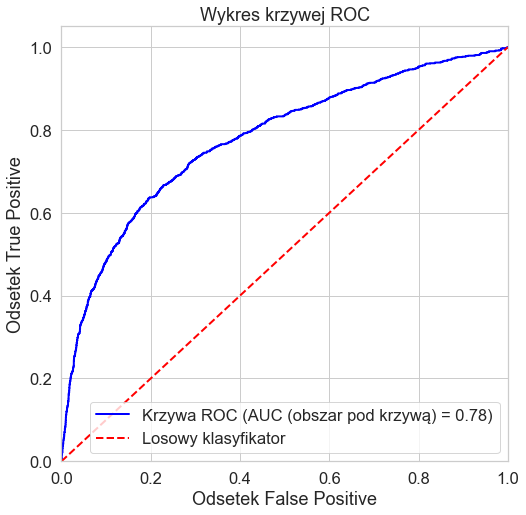

Pole pod krzywą ROC - AUC: 0.78
Współczynnik Giniego: 0.56


In [102]:
#Wywołanie funkcji do oceny modelu  
ocena_modelu(y_vali, y_pred)


Wykres Krzywej ROC jest najbardziej oddalony od lini losowego klasyfikatora w początkowym fragmencie i osiąga maksimum około pierwszej ćwiartki wykresu. Wskazuje to, że szukany optymalny punkt odcięcia (wyznaczony w kolejnym etapie) będzie znajdował się w tym obszarze.<br>
Wartość AUC oraz współczynnika Giniego są akceptowalne, choć ich wartości nie są bardzo duże.

<a class="anchor" id="model_fin"></a>
## Finalna weryfikacja jakości modelu
[Powrót do spisu treści](#toc)

Finalna weryfikacja modelu została przeprowadzona na zbiorze danych testowych, przy uwzględnieniu w modelowaniu  wybranych na wcześniejszym etapie atrybutów.

<a class="anchor" id="budowa_fin"></a>
### Model finalny

In [103]:
y_pred_fin = model.predict_proba(x_test[atrybuty_wybrane]) #sprawdzenie modelu dla danych walidacyjnych
y_pred_fin = y_pred_fin[:, 1] #przepisanie tylko kolumny z danymi zmiennej celu

<a class="anchor" id="ocena_fin"></a>
### Ocena modelu dla zbioru testowego

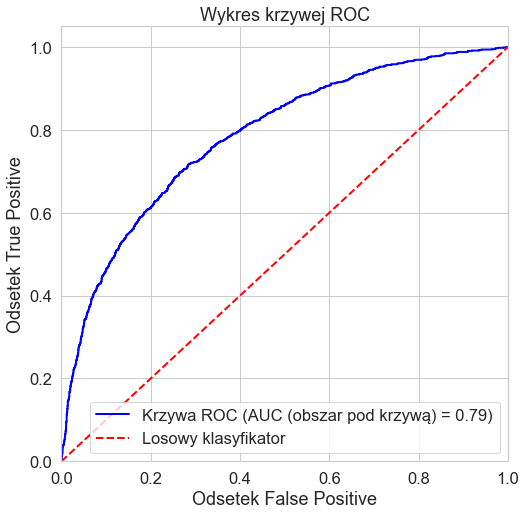

Pole pod krzywą ROC - AUC: 0.79
Współczynnik Giniego: 0.57


In [104]:
ocena_modelu(y_test, y_pred_fin)

Jak widać finalny model klasyfikatora ma prawie identyczne parametry jakości w porównaniu do wartości ze zbioru walidacyjnego i moża je uznać za zadawalające. Wyniki dla zbioru testowego nie odbiegają od wyników dla zbioru walidacyjnego więc model można uznać za nieprzetrenowany i powinien uzyskiwać podobne wyniki na rzeczywistych danych.

<a class="anchor" id="punkt"></a>
### Wyznaczanie optymalnego punktu odcięcia

In [105]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 50
punkt_odciecia_fin, max_dochod, dochody = punkt_odciecia(y_test, y_pred_fin, 15, 50)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.'
          .format(max_dochod, punkt_odciecia_fin))

Największy dochód wynosi: 25130, któremu odpowiada punkt odcięcia: 0.19.


<a class="anchor" id="ocena_punkt"></a>
### Ocena klasyfikatora z uwzględnieniem  optymalnego punktu odcięcia
 Dla obliczonej wartości punktu odcięcia wyznaczono wskaźniki jakości modelu oraz macierz pomyłek.

In [106]:
#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin)

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      3933
           1       0.44      0.72      0.54      1208

    accuracy                           0.72      5141
   macro avg       0.66      0.72      0.67      5141
weighted avg       0.78      0.72      0.73      5141

Dokładność: 0.72
Błąd: 0.28
Specyficzność: 0.71
Czułość: 0.72
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              2812              1121
Prawdziwe "1"               341               867


<a class="anchor" id="rentownosc"></a>
### Podsumowanie wyników i wyznaczenie rentowności
Rentowność klasyfikatora obliczana jest z uwzględnieniem optymalnego punktu odcięcia

In [107]:
#Założone wartości zysku i straty
zysk = 15
strata = 50

print('Dla założonych zysku {} i straty {} otrzymano: \n'.format(zysk,strata))
print('- Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))
print('- Wartość uzyskanego dochodu: ', max_dochod)

print('- Ilość badanych klientów:', tn + fn + fp + tp)
print('- Ilość klientów sklasyfikowanych jako wiarygodnych:', tn + fn)
print('- Ilość klientów sklasyfikowanych jako niewiarygodnych:', fp + tp)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych:', tn)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych:', fn)
print('- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', fp)
print('- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych:', tp)

Dla założonych zysku 15 i straty 50 otrzymano: 

- Rentowność: 7.97%
- Wartość uzyskanego dochodu:  25130
- Ilość badanych klientów: 5141
- Ilość klientów sklasyfikowanych jako wiarygodnych: 3153
- Ilość klientów sklasyfikowanych jako niewiarygodnych: 1988
- Ilość wiarygodnych klientów sklasyfikowanych jako wiarygodnych: 2812
- Ilość niewiarygodnych klientów sklasyfikowanych jako wiarygodnych: 341
- Ilość wiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 1121
- Ilość niewiarygodnych klientów sklasyfikowanych jako niewiarygodnych: 867


<font color='red'>
Na podstawie przeprowadzonej analizy wykonanego modelu można stwierdzić, że jakość modelu biorąc pod uwagę uzyskany dochód z całego portfela kredytów jest satysfakcjonujący. 
 </font>

<a class="anchor" id="inne_doch"></a>
### Wyznaczenie dochodów dla innych zysków i strat dla modelu

In [108]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 15 i straty równej 75
punkt_odciecia_fin_cat_15_75, max_dochod_cat_15_75, dochody_cat_15_75 = punkt_odciecia(y_test, y_pred_fin, 15, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_cat_15_75, punkt_odciecia_fin_cat_15_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_cat_15_75)

#Założone wartości zysku i straty
zysk = 15
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 17235, któremu odpowiada punkt odcięcia: 0.16.

              precision    recall  f1-score   support

           0       0.90      0.64      0.75      3933
           1       0.40      0.78      0.52      1208

    accuracy                           0.67      5141
   macro avg       0.65      0.71      0.64      5141
weighted avg       0.78      0.67      0.69      5141

Dokładność: 0.67
Błąd: 0.33
Specyficzność: 0.64
Czułość: 0.78
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              2504              1429
Prawdziwe "1"               271               937

 Rentowność: 6.21%


In [109]:
#Wyznaczenie punktu odcięcia i maksymalnego dochodu dla zysku równego 10 i straty równej 75
punkt_odciecia_fin_cat_10_75, max_dochod_cat_10_75, dochody_cat_10_75 = punkt_odciecia(y_test, y_pred_fin, 10, 75)
print('Największy dochód wynosi: {}, któremu odpowiada punkt odcięcia: {}.\n'
          .format(max_dochod_cat_10_75, punkt_odciecia_fin_cat_10_75))

#Wywołanie funkcji do wyznaczenia wskaźników modelu
tn, fp, fn, tp, dokladnosc, blad, specyficznosc, czulosc, macierz_pomylek = wskazniki_modelu(y_test, y_pred_fin, punkt_odciecia_fin_cat_10_75)

#Założone wartości zysku i straty
zysk = 10
strata = 75
print('\n Rentowność: {}%'.format(((tn * zysk + fn * -strata)/(tn + fn)).round(2)))

Największy dochód wynosi: 7320, któremu odpowiada punkt odcięcia: 0.11.

              precision    recall  f1-score   support

           0       0.93      0.43      0.58      3933
           1       0.32      0.90      0.48      1208

    accuracy                           0.54      5141
   macro avg       0.63      0.66      0.53      5141
weighted avg       0.79      0.54      0.56      5141

Dokładność: 0.54
Błąd: 0.46
Specyficzność: 0.43
Czułość: 0.9
               Prognozowane "0"  Prognozowane "1"
Prawdziwe "0"              1677              2256
Prawdziwe "1"               126              1082

 Rentowność: 4.06%
